**TÍTULO: AÇÕES DO SETOR BANCÁRIO BRASILEIRO – MODELOS PREDITIVOS DE MACHINE LEARNING EM SÉRIES TEMPORAIS**

**ALUNO: Danilo Rocha Nunes**

**Notebook referente ao Trabalho de Conclusão de Curso de pós-graduação em Ciências de Dados e Big Data pela Pontifícia Universidade Católica de Minas Gerais - PUC Minas**

**>>>>>Notebook auxiliar ao código principal, utilizado com objetivo de avaliação de modelos de Machine Learning**

### 1. Importando as bibliotecas necessárias ao projeto

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import datetime
from datetime import datetime
from pandas_datareader import data, wb

from copy import copy
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Importando os modelos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#Importando a biblioteca de pré processamento dos dados
from sklearn.preprocessing import MinMaxScaler

# Importando as bibliotecas de LSTM
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Model
from keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation

#Usado para salvar o modelo
from tensorflow.keras.models import load_model

%matplotlib inline

### 2. Instalando e Importando Biblioteca TA-LIB para análise técnica de ações

In [2]:
# download TA-Lib 
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 

!tar xvzf ta-lib-0.4.0-src.tar.gz

import os

os.chdir('ta-lib') # Can't use !cd in co-lab

!./configure --prefix=/usr

!make

!make install
# wait ~ 30s

os.chdir('../')

!pip install TA-Lib

import talib as ta

--2021-04-08 15:07:25--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-04-08 15:07:25--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-04-08 15:07:25--  https://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl.so

### 3. Importando dados históricos das ações de Bancos

In [3]:
# Definir o período para importação dos valores das ações
start_date = datetime(2010,1,1)
#now = datetime.now()

#end_date = datetime(now.year,now.month,now.day-2)
#end_date = datetime(2021,3,22)
end_date = datetime(2021,1,1)

In [4]:
# Importar os dados das ações de bancos
BBAS = data.DataReader("BBAS3.SA",'yahoo',start_date,end_date)
BBDC = data.DataReader("BBDC4.SA",'yahoo',start_date,end_date)
ITUB = data.DataReader("ITUB4.SA",'yahoo',start_date,end_date)
SANB = data.DataReader("SANB11.SA",'yahoo',start_date,end_date)


### 4. Importando dados históricos das ações de Petrobras e Vale para análise comparativa

In [5]:
PETR = data.DataReader("PETR4.SA",'yahoo',start_date,end_date)
VALE = data.DataReader("VALE3.SA",'yahoo',start_date,end_date)

### 5. Importando dados históricos do IBOVESPA e Dólar

In [6]:
#Importar os dados da IBOVESPA e Valores de Fechamento do Dólar
IBOV = data.DataReader("^BVSP",'yahoo',start_date,end_date)
USDBRL = data.DataReader("BRL=X",'yahoo',start_date,end_date)
USDBRL.drop('High', axis=1, inplace=True)
USDBRL.drop('Low', axis=1, inplace=True)
USDBRL.drop('Open', axis=1, inplace=True)
USDBRL.drop('Volume', axis=1, inplace=True)
USDBRL.drop('Adj Close', axis=1, inplace=True)
USDBRL.tail()

,Close
Date,
2020-12-28,5.215300
2020-12-29,5.245900
2020-12-30,5.208600
2020-12-31,5.190839
2021-01-01,5.192100


### 6. Importando dados econômicos da API do Banco Central do Brasil

In [7]:
#Definindo função para obtenção de dados da API do Banco Central
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [8]:
#Importando a Selic Anual
selic_anual = consulta_bc(432)
selic_anual = selic_anual[selic_anual.index.year >= 2010]
selic_anual.tail()

,valor
data,
2021-05-01,2.75
2021-05-02,2.75
2021-05-03,2.75
2021-05-04,2.75
2021-05-05,2.75


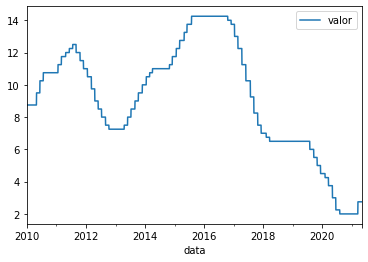

In [9]:
selic_anual.plot()

In [10]:
#Importando a Selic Diária e definindo o perído de utilização
selic_diaria = consulta_bc(11)
selic_diaria = selic_diaria[selic_diaria.index.year >= start_date.year]
selic_diaria = selic_diaria[selic_diaria.index.year < end_date.year]

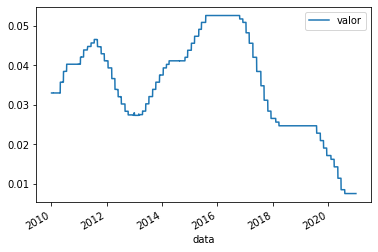

In [11]:
selic_diaria.plot()

### 7 - Definindo funções que serão utilizadas no curso do Projeto

In [12]:
#Função Utilizada para Normalizar os Dados
def normalize(df):
  x = df.copy()
  for i in x.columns[0:]:
    x[i] = x[i]/x[i][0]
  return x

In [13]:
# Function to plot interactive plots using Plotly Express
def interactive_plot(df , title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['Data'], y = df[i], name = i)
  #fig.update_layout(legend=dict(yanchor="top", y=0.01, xanchor="left", x=0.01))
  fig.show()

In [14]:
# Function to plot interactive plots using Plotly Express
def interactive_plot_index(df , title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df.index, y = df[i], name = i)
  fig.show()

In [15]:
#Plotagem dos dados de treinamento e teste
def plot_data_train_test_prediction(df_stock,df_predicted,stock_ticker,split,forecast_target):
  fig = px.line(title=stock_ticker+' - Dados de treinamento x Dados de teste X Dados de Predição')
  fig.add_scatter(x = df_stock[stock_ticker]['Close'][:split+forecast_target+1].index, y = df_stock[stock_ticker]['Close'][:split+forecast_target+1], name = 'Dados de Treinamento - '+stock_ticker,marker=dict(color="green"))
  #fig.add_scatter(x = df_stock[stock_ticker][:split+forecast_target+1].index, y = df_stock[stock_ticker][:split+forecast_target+1], name = 'Dados de Treinamento - '+stock_ticker,marker=dict(color="green"))
  fig.add_scatter(x = df_predicted['Target Close'].index, y = df_predicted['Target Close'], name = 'Dados de Fechamento - '+stock_ticker,marker=dict(color="blue"))
  fig.add_scatter(x = df_predicted['Prediction'].index, y = df_predicted['Prediction'], name = 'Dados de Predição - '+stock_ticker,marker=dict(color="red"))
  fig.show()

In [16]:
#Função para impressão de indicadores do modelo
def print_model_scores(model_title,y_test,predicted):
  
  # Calculo do R2 Score
  print(model_title+" - R2 Score: ", r2_score(y_test,predicted))
  print('\n')
  #Cálculo do erro
  print(model_title+' - MAE: ', mean_absolute_error(y_test,predicted))
  print(model_title+' - MSE: ', mean_squared_error(y_test,predicted))
  print(model_title+' - RMSE: ', np.sqrt(mean_squared_error(y_test,predicted)))

In [17]:
#Função para impressão de indicadores do modelo
def assign_model_scores(model_title,y_test,predicted, stock_ticker_id, df):
  df = df.append({'1 - Metric':model_title,
                  '2 - '+stock_ticker_id+' - R2 Score': r2_score(y_test,predicted),
                  '3 - '+stock_ticker_id+' - MAE': mean_absolute_error(y_test,predicted),
                  '4 - '+stock_ticker_id+' - MSE': mean_squared_error(y_test,predicted),
                  '5 - '+stock_ticker_id+' - RMSE': np.sqrt(mean_squared_error(y_test,predicted))}, ignore_index=True)

  return df

In [18]:
def assign_model_scores_values(model_title,r2_score,MAE,MSE,RMSE, stock_ticker_id, df):
  df = df.append({'1 - Metric':model_title,
                  '2 - '+stock_ticker_id+' - R2 Score': r2_score,
                  '3 - '+stock_ticker_id+' - MAE': MAE,
                  '4 - '+stock_ticker_id+' - MSE': MSE,
                  '5 - '+stock_ticker_id+' - RMSE': RMSE}, ignore_index=True)

  return df

In [19]:
#Definindo uma função para criar o DataFrame com preço de fechamento
def individual_stock_close(dados, name):
  return pd.DataFrame({'Close':dados[name]['Close']})

In [20]:
#Definindo uma função para criar o DataFrame com preço de fechamento
def individual_stock_close_volume(dados, name):
  return pd.DataFrame({'Close':dados[name]['Close'],'Volume':dados[name]['Volume']})

In [21]:
#Definindo uma função para criar o DataFrame com Data, Preço, Volume e Dolar para uma ação específica
def individual_stock_close_volume_dolar(dados, name):
  return pd.DataFrame({'Close':dados[name]['Close'],'Volume':dados[name]['Volume'],'Dolar':dados['USD']['Close']})

In [22]:
#Definindo uma função para criar o DataFrame com Data, Preço, Volume e Selic para uma ação específica
def individual_stock_close_volume_selic_dolar(dados, name):
  return pd.DataFrame({'Close':dados[name]['Close'],'Volume':dados[name]['Volume'],'Selic':dados['Selic']['Close'],'Dolar':dados['USD']['Close']})

In [23]:
#Definindo uma função para criar o DataFrame com Data, Preço, Volume, Selic, Retorno e Média Móvel 7 dias
def individual_stock_technical_features(dados, name):
  df = pd.DataFrame();
  df['EMAClose'] = ta.EMA(dados[name]['Close'],timeperiod=7) # Média Móvel Exponencial de 7 dias de fechamento - Exponencial Moving Average
  df['EMAOpen'] = ta.EMA(dados[name]['Open'],timeperiod=7) # Média Móvel Exponencial de 7 dias de abertura - Exponencial Moving Average
  df['EMAHigh'] = ta.EMA(dados[name]['High'],timeperiod=7) # Média Móvel Exponencial de 7 dias de maior valor - Exponencial Moving Average
  df['EMALow'] = ta.EMA(dados[name]['Low'],timeperiod=7) # Média Móvel Exponencial de 7 dias de menor valor - Exponencial Moving Average
  df['RSI'] = ta.RSI(df['EMAClose'],timeperiod=14) #Índice de Força Relativa - Relative Strenght Index
  df['WILLR'] = ta.WILLR(df['EMAHigh'], df['EMALow'], df['EMAClose'],timeperiod=14) #Índice de Força Relativa - Relative Strenght Index
  df['MACD'], df['MACDsignal'], df['MACDhist'] = ta.MACD(df['EMAClose'], fastperiod=12, slowperiod=26,signalperiod=9) #Convergência Divergência da Média Móvel = Moving Average Convergence Divergence
  df['OBV'] = ta.OBV(df['EMAClose'], dados[name]['Volume']) # Volume Balanceado - On Balance Volume
  df['ROC'] = ta.ROC(df['EMAClose'],timeperiod=14) #Taxa de Alteração de Preço - Price Rate of Change
  df['fastk'],df['fastd'] = ta.STOCHRSI(df['EMAClose'],timeperiod=14,fastk_period=5,fastd_period=3,fastd_matype=0) # Oscilador Estocástico

  #Preenchendo as informações faltantes
  df.fillna(method='ffill',inplace=True)
  df.fillna(method='bfill',inplace=True)

  return pd.DataFrame({'Close': dados[name]['Close'],
                       'RSI' : df['RSI'],
                       'WILLR' : df['WILLR'],
                       'MACD' : df['MACD'],
                       'MACDsignal' : df['MACDsignal'],
                       'MACDhist' : df['MACDhist'],
                       'OBV' : df['OBV'],
                       'ROC' : df['ROC'],
                       'fastk' : df['fastk'],
                       'fastd' : df['fastd']})

In [24]:
#Definindo uma função para criar o DataFrame com Data, Preço, Volume, Selic, Retorno e Média Móvel 7 dias
def individual_stock_tech_all_features(dados, name):
  df = pd.DataFrame();
  df['EMAClose'] = ta.EMA(dados[name]['Close'],timeperiod=7) # Média Móvel Exponencial de 7 dias de fechamento - Exponencial Moving Average
  df['EMAOpen'] = ta.EMA(dados[name]['Open'],timeperiod=7) # Média Móvel Exponencial de 7 dias de abertura - Exponencial Moving Average
  df['EMAHigh'] = ta.EMA(dados[name]['High'],timeperiod=7) # Média Móvel Exponencial de 7 dias de maior valor - Exponencial Moving Average
  df['EMALow'] = ta.EMA(dados[name]['Low'],timeperiod=7) # Média Móvel Exponencial de 7 dias de menor valor - Exponencial Moving Average
  df['RSI'] = ta.RSI(df['EMAClose'],timeperiod=14) #Índice de Força Relativa - Relative Strenght Index
  df['WILLR'] = ta.WILLR(df['EMAHigh'], df['EMALow'], df['EMAClose'],timeperiod=14) #Índice de Força Relativa - Relative Strenght Index
  df['MACD'], df['MACDsignal'], df['MACDhist'] = ta.MACD(df['EMAClose'], fastperiod=12, slowperiod=26,signalperiod=9) #Convergência Divergência da Média Móvel = Moving Average Convergence Divergence
  df['OBV'] = ta.OBV(df['EMAClose'], dados[name]['Volume']) # Volume Balanceado - On Balance Volume
  df['ROC'] = ta.ROC(df['EMAClose'],timeperiod=14) #Taxa de Alteração de Preço - Price Rate of Change
  df['fastk'],df['fastd'] = ta.STOCHRSI(df['EMAClose'],timeperiod=14,fastk_period=5,fastd_period=3,fastd_matype=0) # Oscilador Estocástico

  #Preenchendo as informações faltantes
  df.fillna(method='ffill',inplace=True)
  df.fillna(method='bfill',inplace=True)

  return pd.DataFrame({'Close': dados[name]['Close'],
                       'EMAClose': df['EMAClose'],
                       'EMAOpen': df['EMAOpen'],
                       'EMAHigh': df['EMAHigh'],
                       'EMALow' : df['EMALow'],
                       'RSI' : df['RSI'],
                       'WILLR' : df['WILLR'],
                       'MACD' : df['MACD'],
                       'MACDsignal' : df['MACDsignal'],
                       'MACDhist' : df['MACDhist'],
                       'OBV' : df['OBV'],
                       'ROC' : df['ROC'],
                       'fastk' : df['fastk'],
                       'fastd' : df['fastd']})

In [25]:
#Definindo uma função para criar o DataFrame com Data, Preço, Volume, Selic, Retorno e Média Móvel 7 dias
def individual_stock_all_features(dados, name):
  df = pd.DataFrame();
  df['EMAClose'] = ta.EMA(dados[name]['Close'],timeperiod=7) # Média Móvel Exponencial de 7 dias de fechamento - Exponencial Moving Average
  df['EMAOpen'] = ta.EMA(dados[name]['Open'],timeperiod=7) # Média Móvel Exponencial de 7 dias de abertura - Exponencial Moving Average
  df['EMAHigh'] = ta.EMA(dados[name]['High'],timeperiod=7) # Média Móvel Exponencial de 7 dias de maior valor - Exponencial Moving Average
  df['EMALow'] = ta.EMA(dados[name]['Low'],timeperiod=7) # Média Móvel Exponencial de 7 dias de menor valor - Exponencial Moving Average
  df['RSI'] = ta.RSI(df['EMAClose'],timeperiod=14) #Índice de Força Relativa - Relative Strenght Index
  df['WILLR'] = ta.WILLR(df['EMAHigh'], df['EMALow'], df['EMAClose'],timeperiod=14) #Índice de Força Relativa - Relative Strenght Index
  df['MACD'], df['MACDsignal'], df['MACDhist'] = ta.MACD(df['EMAClose'], fastperiod=12, slowperiod=26,signalperiod=9) #Convergência Divergência da Média Móvel = Moving Average Convergence Divergence
  df['OBV'] = ta.OBV(df['EMAClose'], dados[name]['Volume']) # Volume Balanceado - On Balance Volume
  df['ROC'] = ta.ROC(df['EMAClose'],timeperiod=14) #Taxa de Alteração de Preço - Price Rate of Change
  df['fastk'],df['fastd'] = ta.STOCHRSI(df['EMAClose'],timeperiod=14,fastk_period=5,fastd_period=3,fastd_matype=0) # Oscilador Estocástico
  df['Return'] = pd.DataFrame(dados[name]['Close'].pct_change() * 100)
  df['Return'] = df['Return'].fillna(0)

  #Preenchendo as informações faltantes
  df.fillna(method='ffill',inplace=True)
  df.fillna(method='bfill',inplace=True)

  return pd.DataFrame({'Close': dados[name]['Close'],
                       'Volume': dados[name]['Volume'],
                       'Selic': dados['Selic']['Close'],
                       'Dolar': dados['USD']['Close'],
                       'Return':  df['Return'],
                       'EMAClose': df['EMAClose'],
                       'EMAOpen': df['EMAOpen'],
                       'EMAHigh': df['EMAHigh'],
                       'EMALow' : df['EMALow'],
                       'RSI' : df['RSI'],
                       'WILLR' : df['WILLR'],
                       'MACD' : df['MACD'],
                       'MACDsignal' : df['MACDsignal'],
                       'MACDhist' : df['MACDhist'],
                       'OBV' : df['OBV'],
                       'ROC' : df['ROC'],
                       'fastk' : df['fastk'],
                       'fastd' : df['fastd']                       })

In [26]:
#Criar uma função para definir o retorno diário
def stock_return_function(data,dados,stock_ticker_id,split):
  n = 1
  data['Return'] = dados[stock_ticker_id]['Close']-data['Open']
  return data

In [27]:
#Criar uma função para definir o ALVO da análise com base no valor de fechamento e na janela de dias para predição (n)
def trading_window(data,n_days):
  #n = 1
  data['Target'] = data[['Close']].shift(-n_days)
  return data

In [28]:
#Define a data plotting function
def show_plot(data,title):
  plt.figure(figsize= (13,5))
  plt.plot(data, linewidth = 3)
  plt.title(title)
  plt.legend(loc="upper left")
  plt.grid()

In [29]:
#Calcula o retorno usando o algoritmo
def Portfolio_return_ML_x_BuyHold(df_portfolio,stock_list):
  stock_return_dict = []
  portfolio_return_ML = []
  portfolio_return_Buy_Hold = []

  for i_stock in stock_list:
    number_buy_operations = 0
    number_day_markets = 0
    stock_return = 0
    i=0
    for i in range(len(df_portfolio)):
      number_day_markets = number_day_markets +1
      if  df_portfolio.iloc[i][i_stock+' Prediction'] > df_portfolio.iloc[i][i_stock+' Close']:
        if number_buy_operations == 0:
          first_buy = i
        number_buy_operations = number_buy_operations+1
        stock_return = stock_return + df_portfolio.iloc[i][i_stock+' Target Close'] - df_portfolio.iloc[i][i_stock+' Close']
    stock_return_dict.append({i_stock +' 1 - Return Machine Learning (%)': 100*stock_return/df_portfolio.iloc[first_buy][i_stock+' Close'],
                              i_stock+' 2 - Buy and Hold Return (%)' : 100*(df_portfolio.iloc[-1][i_stock+' Target Close']-df_portfolio.iloc[0][i_stock+' Close'])/df_portfolio.iloc[0][i_stock+' Close'],
                              i_stock+' 3 - Número de dias com compras' : number_buy_operations,
                              i_stock+' 4 - Número de dias de negociações' : number_day_markets,
                              i_stock+' 5 - First Close' : df_portfolio.iloc[0][i_stock+' Close'],
                              i_stock+' 6 - Last Close' : df_portfolio.iloc[-1][i_stock+' Target Close'],})
    portfolio_return_ML.append(100*stock_return/df_portfolio.iloc[0][i_stock+' Close'])
    portfolio_return_Buy_Hold.append(100*(df_portfolio.iloc[-1][i_stock+' Target Close']-df_portfolio.iloc[0][i_stock+' Close'])/df_portfolio.iloc[0][i_stock+' Close'])

  #print('PortFolio Return - Machine Learning (%): ', np.mean(portfolio_return_ML))
  #print('PortFolio Return - Buy and Hold (%): ', np.mean(portfolio_return_Buy_Hold))

  return stock_return_dict, np.mean(portfolio_return_ML), np.mean(portfolio_return_Buy_Hold)

### 8. Criando a base de dados para trabalho

In [30]:
tickers = ['BBAS','BBDC','ITUB','SANB','IBOV','PETR','VALE','USD','Selic']
tickers

['BBAS', 'BBDC', 'ITUB', 'SANB', 'IBOV', 'PETR', 'VALE', 'USD', 'Selic']

In [31]:
dados = pd.concat([BBAS,BBDC,ITUB,SANB,IBOV,PETR,VALE,USDBRL,selic_diaria],axis=1,keys=tickers)
dados.head()

BBAS                        ...       VALE     USD     Selic
                 High        Low       Open  ...  Adj Close   Close     valor
2010-01-04  30.000000  29.700001  29.799999  ...  32.089706  1.7190  0.032927
2010-01-05  30.100000  29.190001  30.100000  ...  32.388855  1.7370  0.032927
2010-01-06  30.000000  29.420000  29.490000  ...  33.074394  1.7315  0.032927
2010-01-07  29.709999  29.410000  29.440001  ...  33.211502  1.7389  0.032927
2010-01-08  29.820000  29.469999  29.700001  ...  33.535576  1.7320  0.032927

[5 rows x 44 columns]

In [32]:
dados.columns.names = ['Bank Ticker','Stock Info']
dados.index.name = 'Data'
dados.head()

Bank Ticker       BBAS                        ...       VALE     USD     Selic
Stock Info        High        Low       Open  ...  Adj Close   Close     valor
Data                                          ...                             
2010-01-04   30.000000  29.700001  29.799999  ...  32.089706  1.7190  0.032927
2010-01-05   30.100000  29.190001  30.100000  ...  32.388855  1.7370  0.032927
2010-01-06   30.000000  29.420000  29.490000  ...  33.074394  1.7315  0.032927
2010-01-07   29.709999  29.410000  29.440001  ...  33.211502  1.7389  0.032927
2010-01-08   29.820000  29.469999  29.700001  ...  33.535576  1.7320  0.032927

[5 rows x 44 columns]

### 9. Trabalhando os dados faltantes (feriados nacionais, internacionais, dados faltantes de alguns ativos)

In [33]:
dados.isnull()

Bank Ticker   BBAS                       ...   VALE              USD  Selic
Stock Info    High    Low   Open  Close  ... Volume Adj Close  Close  valor
Data                                     ...                               
2010-01-04   False  False  False  False  ...  False     False  False  False
2010-01-05   False  False  False  False  ...  False     False  False  False
2010-01-06   False  False  False  False  ...  False     False  False  False
2010-01-07   False  False  False  False  ...  False     False  False  False
2010-01-08   False  False  False  False  ...  False     False  False  False
...            ...    ...    ...    ...  ...    ...       ...    ...    ...
2020-12-28   False  False  False  False  ...  False     False  False  False
2020-12-29   False  False  False  False  ...  False     False  False  False
2020-12-30   False  False  False  False  ...  False     False  False  False
2020-12-31    True   True   True   True  ...   True      True  False  False
2021-01-01    True   True   True   True  ...   True      True  False   True

[3186 rows x 44 columns]

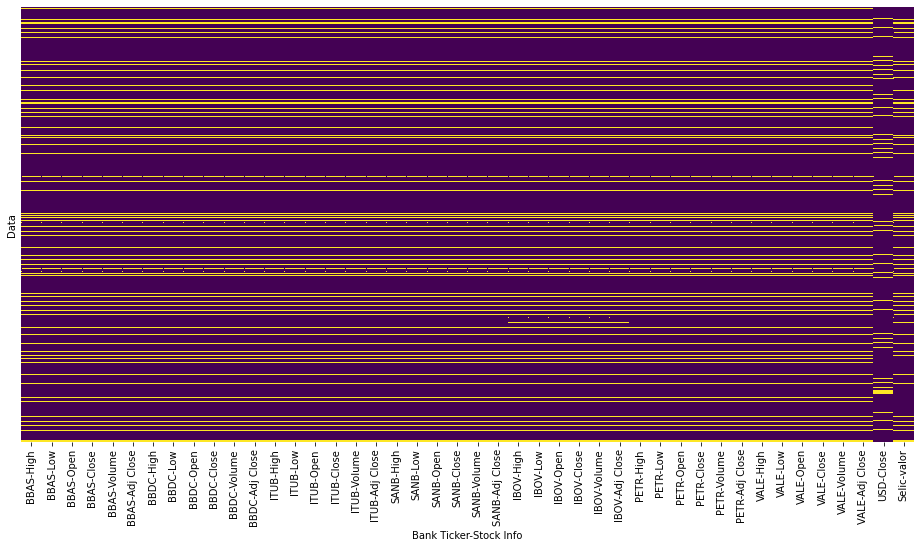

In [34]:
plt.figure(figsize = (16,8))
sns.heatmap(dados.isnull(),yticklabels=False,cbar=False,cmap='viridis')

9.1 - Trabalhando os dados faltantes do US Dólar

In [35]:
#Verificando quantidade de dados faltantes
dados.isnull().value_counts()

(BBAS, High)  (BBAS, Low)  (BBAS, Open)  (BBAS, Close)  (BBAS, Volume)  (BBAS, Adj Close)  (BBDC, High)  (BBDC, Low)  (BBDC, Open)  (BBDC, Close)  (BBDC, Volume)  (BBDC, Adj Close)  (ITUB, High)  (ITUB, Low)  (ITUB, Open)  (ITUB, Close)  (ITUB, Volume)  (ITUB, Adj Close)  (SANB, High)  (SANB, Low)  (SANB, Open)  (SANB, Close)  (SANB, Volume)  (SANB, Adj Close)  (IBOV, High)  (IBOV, Low)  (IBOV, Open)  (IBOV, Close)  (IBOV, Volume)  (IBOV, Adj Close)  (PETR, High)  (PETR, Low)  (PETR, Open)  (PETR, Close)  (PETR, Volume)  (PETR, Adj Close)  (VALE, High)  (VALE, Low)  (VALE, Open)  (VALE, Close)  (VALE, Volume)  (VALE, Adj Close)  (USD, Close)  (Selic, valor)
False         False        False         False          False           False              False         False        False         False          False           False              False         False        False         False          False           False              False         False        False         False          False

In [36]:
#Verificando a data onde o dólar é nulo
dados[dados['USD']['Close'].isnull()==True]

Bank Ticker       BBAS                        ...       VALE   USD     Selic
Stock Info        High        Low       Open  ...  Adj Close Close     valor
Data                                          ...                           
2010-04-09   31.100000  30.520000  30.809999  ...  36.950844   NaN  0.032927
2010-04-16   30.900000  30.350000  30.610001  ...  36.736004   NaN  0.032927
2010-04-23   29.930000  29.389999  29.520000  ...  35.399120   NaN  0.032890
2010-04-30   30.400000  29.610001  29.870001  ...  33.327900   NaN  0.035657
2010-05-07   28.000000  26.379999  27.910000  ...  31.193907   NaN  0.035657
...                ...        ...        ...  ...        ...   ...       ...
2020-09-25   30.480000  29.969999  30.240000  ...  56.695858   NaN  0.007469
2020-10-02   30.740000  29.309999  29.410000  ...  55.805950   NaN  0.007469
2020-10-09   31.670000  30.629999  31.110001  ...  58.944553   NaN  0.007469
2020-10-16   31.020000  30.250000  30.910000  ...  59.556969   NaN  0.007469
2020-10-23   34.290001  33.330002  33.669998  ...  60.714806   NaN  0.007469

[342 rows x 44 columns]

In [37]:
# Verificando os campos do USD
dados['USD']

Stock Info,Close
Data,
2010-01-04,1.719000
2010-01-05,1.737000
2010-01-06,1.731500
2010-01-07,1.738900
2010-01-08,1.732000
...,...
2020-12-28,5.215300
2020-12-29,5.245900
2020-12-30,5.208600


In [38]:
# Preencher o valor faltante do dólar com o último valor disponível
dados['USD']['Close'].fillna(method='ffill',inplace=True)

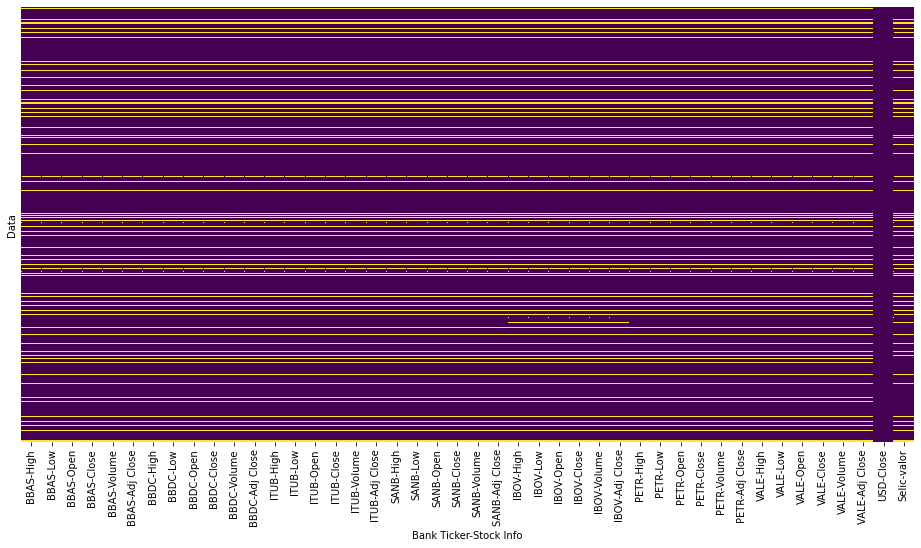

In [39]:
plt.figure(figsize = (16,8))
sns.heatmap(dados.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [40]:
#Verificando novamente os dados nulos
dados.isnull().value_counts()

(BBAS, High)  (BBAS, Low)  (BBAS, Open)  (BBAS, Close)  (BBAS, Volume)  (BBAS, Adj Close)  (BBDC, High)  (BBDC, Low)  (BBDC, Open)  (BBDC, Close)  (BBDC, Volume)  (BBDC, Adj Close)  (ITUB, High)  (ITUB, Low)  (ITUB, Open)  (ITUB, Close)  (ITUB, Volume)  (ITUB, Adj Close)  (SANB, High)  (SANB, Low)  (SANB, Open)  (SANB, Close)  (SANB, Volume)  (SANB, Adj Close)  (IBOV, High)  (IBOV, Low)  (IBOV, Open)  (IBOV, Close)  (IBOV, Volume)  (IBOV, Adj Close)  (PETR, High)  (PETR, Low)  (PETR, Open)  (PETR, Close)  (PETR, Volume)  (PETR, Adj Close)  (VALE, High)  (VALE, Low)  (VALE, Open)  (VALE, Close)  (VALE, Volume)  (VALE, Adj Close)  (USD, Close)  (Selic, valor)
False         False        False         False          False           False              False         False        False         False          False           False              False         False        False         False          False           False              False         False        False         False          False

9.2 - Verificando datas onde a Taxa Selic Diária é nula

In [41]:
#Verificando a data onde a Selic é nula
dados[dados['Selic']['valor'].isnull()==True]

Bank Ticker BBAS                        ...  VALE                      USD Selic
Stock Info  High Low Open Close Volume  ... Close Volume Adj Close   Close valor
Data                                    ...                                     
2010-02-15   NaN NaN  NaN   NaN    NaN  ...   NaN    NaN       NaN  1.8514   NaN
2010-02-16   NaN NaN  NaN   NaN    NaN  ...   NaN    NaN       NaN  1.8425   NaN
2010-03-28   NaN NaN  NaN   NaN    NaN  ...   NaN    NaN       NaN  1.8085   NaN
2010-04-04   NaN NaN  NaN   NaN    NaN  ...   NaN    NaN       NaN  1.7605   NaN
2010-04-11   NaN NaN  NaN   NaN    NaN  ...   NaN    NaN       NaN  1.7562   NaN
...          ...  ..  ...   ...    ...  ...   ...    ...       ...     ...   ...
2020-10-12   NaN NaN  NaN   NaN    NaN  ...   NaN    NaN       NaN  5.5297   NaN
2020-10-18   NaN NaN  NaN   NaN    NaN  ...   NaN    NaN       NaN  5.6448   NaN
2020-11-02   NaN NaN  NaN   NaN    NaN  ...   NaN    NaN       NaN  5.7414   NaN
2020-12-25   NaN NaN  NaN   NaN    NaN  ...   NaN    NaN       NaN  5.2153   NaN
2021-01-01   NaN NaN  NaN   NaN    NaN  ...   NaN    NaN       NaN  5.1921   NaN

[423 rows x 44 columns]

In [42]:
dados[dados['Selic']['valor'].isnull()==True].index

DatetimeIndex(['2010-02-15', '2010-02-16', '2010-03-28', '2010-04-04',
               '2010-04-11', '2010-04-18', '2010-04-21', '2010-04-25',
               '2010-05-02', '2010-05-09',
               ...
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',
               '2020-10-11', '2020-10-12', '2020-10-18', '2020-11-02',
               '2020-12-25', '2021-01-01'],
              dtype='datetime64[ns]', name='Data', length=423, freq=None)

In [43]:
dados['Selic']['valor'][dados[dados['Selic']['valor'].isnull()==True].index]

Data
2010-02-15   NaN
2010-02-16   NaN
2010-03-28   NaN
2010-04-04   NaN
2010-04-11   NaN
              ..
2020-10-12   NaN
2020-10-18   NaN
2020-11-02   NaN
2020-12-25   NaN
2021-01-01   NaN
Name: valor, Length: 423, dtype: float64

In [44]:
# Preencher o valor faltante da Selic com o último valor disponível
dados['Selic']['valor'].fillna(method='ffill',inplace=True)

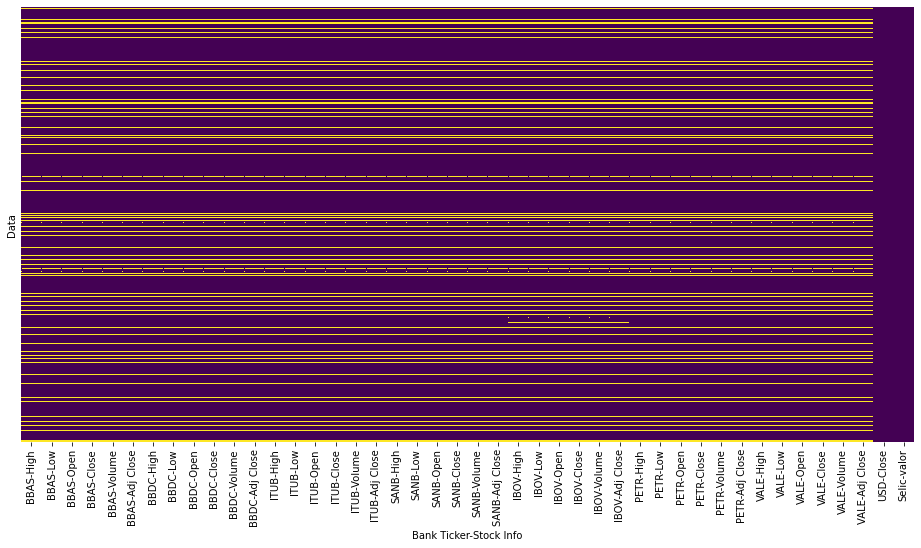

In [45]:
plt.figure(figsize = (16,8))
sns.heatmap(dados.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [46]:
#Verificando novamente os dados nulos
dados.isnull().value_counts()

(BBAS, High)  (BBAS, Low)  (BBAS, Open)  (BBAS, Close)  (BBAS, Volume)  (BBAS, Adj Close)  (BBDC, High)  (BBDC, Low)  (BBDC, Open)  (BBDC, Close)  (BBDC, Volume)  (BBDC, Adj Close)  (ITUB, High)  (ITUB, Low)  (ITUB, Open)  (ITUB, Close)  (ITUB, Volume)  (ITUB, Adj Close)  (SANB, High)  (SANB, Low)  (SANB, Open)  (SANB, Close)  (SANB, Volume)  (SANB, Adj Close)  (IBOV, High)  (IBOV, Low)  (IBOV, Open)  (IBOV, Close)  (IBOV, Volume)  (IBOV, Adj Close)  (PETR, High)  (PETR, Low)  (PETR, Open)  (PETR, Close)  (PETR, Volume)  (PETR, Adj Close)  (VALE, High)  (VALE, Low)  (VALE, Open)  (VALE, Close)  (VALE, Volume)  (VALE, Adj Close)  (USD, Close)  (Selic, valor)
False         False        False         False          False           False              False         False        False         False          False           False              False         False        False         False          False           False              False         False        False         False          False

9.3 - Verificando datas onde o IBOVESPA é faltante (feriados nacionais e São Paulo)

In [47]:
#Verificando a data onde a IBOVESPA é nula
dados[dados['IBOV']['Close'].isnull()==True]

Bank Ticker BBAS                 ...   VALE                 USD     Selic
Stock Info  High Low Open Close  ... Volume Adj Close     Close     valor
Data                             ...                                     
2010-01-25   NaN NaN  NaN   NaN  ...    NaN       NaN  1.783500  0.032927
2010-02-15   NaN NaN  NaN   NaN  ...    NaN       NaN  1.851400  0.032927
2010-02-16   NaN NaN  NaN   NaN  ...    NaN       NaN  1.842500  0.032927
2010-03-28   NaN NaN  NaN   NaN  ...    NaN       NaN  1.808500  0.032927
2010-04-04   NaN NaN  NaN   NaN  ...    NaN       NaN  1.760500  0.032927
...          ...  ..  ...   ...  ...    ...       ...       ...       ...
2020-11-20   NaN NaN  NaN   NaN  ...    NaN       NaN  5.304500  0.007469
2020-12-24   NaN NaN  NaN   NaN  ...    NaN       NaN  5.215300  0.007469
2020-12-25   NaN NaN  NaN   NaN  ...    NaN       NaN  5.215300  0.007469
2020-12-31   NaN NaN  NaN   NaN  ...    NaN       NaN  5.190839  0.007469
2021-01-01   NaN NaN  NaN   NaN  ...    NaN       NaN  5.192100  0.007469

[468 rows x 44 columns]

In [48]:
#Removendo os dias com feriados da base de dados
#data_remove = data[data['IBOV']['Close'].isnull()==True].index()
#data_remove
#data[data['IBOV']['Close'].isnull()==True].index
#Indices=[x for x in data.index if data[data['IBOV']['Close'].isnull()==True]]
dados.drop(dados[dados['IBOV']['Close'].isnull()==True].index,inplace=True)

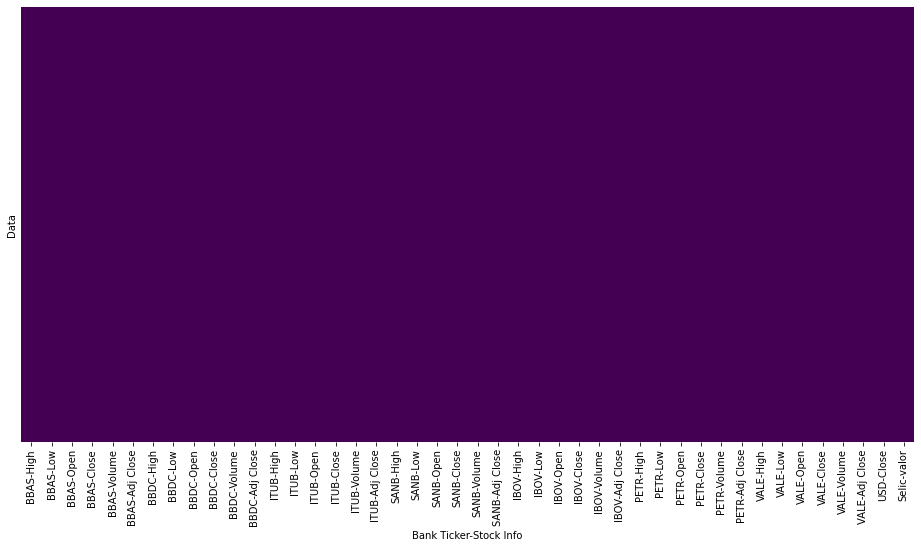

In [49]:
plt.figure(figsize = (16,8))
sns.heatmap(dados.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [50]:
#Verificando novamente dados nulos
dados.isnull().value_counts()

(BBAS, High)  (BBAS, Low)  (BBAS, Open)  (BBAS, Close)  (BBAS, Volume)  (BBAS, Adj Close)  (BBDC, High)  (BBDC, Low)  (BBDC, Open)  (BBDC, Close)  (BBDC, Volume)  (BBDC, Adj Close)  (ITUB, High)  (ITUB, Low)  (ITUB, Open)  (ITUB, Close)  (ITUB, Volume)  (ITUB, Adj Close)  (SANB, High)  (SANB, Low)  (SANB, Open)  (SANB, Close)  (SANB, Volume)  (SANB, Adj Close)  (IBOV, High)  (IBOV, Low)  (IBOV, Open)  (IBOV, Close)  (IBOV, Volume)  (IBOV, Adj Close)  (PETR, High)  (PETR, Low)  (PETR, Open)  (PETR, Close)  (PETR, Volume)  (PETR, Adj Close)  (VALE, High)  (VALE, Low)  (VALE, Open)  (VALE, Close)  (VALE, Volume)  (VALE, Adj Close)  (USD, Close)  (Selic, valor)
False         False        False         False          False           False              False         False        False         False          False           False              False         False        False         False          False           False              False         False        False         False          False

### 10. Preparando os dados para serem trabalhados, com os valores de fechamento diários. Realizando também normalizações

In [51]:
dados

Bank Ticker       BBAS                        ...       VALE       USD     Selic
Stock Info        High        Low       Open  ...  Adj Close     Close     valor
Data                                          ...                               
2010-01-04   30.000000  29.700001  29.799999  ...  32.089706  1.719000  0.032927
2010-01-05   30.100000  29.190001  30.100000  ...  32.388855  1.737000  0.032927
2010-01-06   30.000000  29.420000  29.490000  ...  33.074394  1.731500  0.032927
2010-01-07   29.709999  29.410000  29.440001  ...  33.211502  1.738900  0.032927
2010-01-08   29.820000  29.469999  29.700001  ...  33.535576  1.732000  0.032927
...                ...        ...        ...  ...        ...       ...       ...
2020-12-22   38.860001  38.000000  38.139999  ...  83.192207  5.118938  0.007469
2020-12-23   39.180000  38.270000  38.570000  ...  83.594101  5.156655  0.007469
2020-12-28   39.549999  39.200001  39.320000  ...  83.546249  5.215300  0.007469
2020-12-29   39.599998  38.950001  39.500000  ...  83.316597  5.245900  0.007469
2020-12-30   39.349998  38.660000  39.279999  ...  83.680214  5.208600  0.007469

[2718 rows x 44 columns]

In [52]:
dados.head()

Bank Ticker       BBAS                        ...       VALE     USD     Selic
Stock Info        High        Low       Open  ...  Adj Close   Close     valor
Data                                          ...                             
2010-01-04   30.000000  29.700001  29.799999  ...  32.089706  1.7190  0.032927
2010-01-05   30.100000  29.190001  30.100000  ...  32.388855  1.7370  0.032927
2010-01-06   30.000000  29.420000  29.490000  ...  33.074394  1.7315  0.032927
2010-01-07   29.709999  29.410000  29.440001  ...  33.211502  1.7389  0.032927
2010-01-08   29.820000  29.469999  29.700001  ...  33.535576  1.7320  0.032927

[5 rows x 44 columns]

In [53]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2718 entries, 2010-01-04 to 2020-12-30
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (BBAS, High)       2718 non-null   float64
 1   (BBAS, Low)        2718 non-null   float64
 2   (BBAS, Open)       2718 non-null   float64
 3   (BBAS, Close)      2718 non-null   float64
 4   (BBAS, Volume)     2718 non-null   float64
 5   (BBAS, Adj Close)  2718 non-null   float64
 6   (BBDC, High)       2718 non-null   float64
 7   (BBDC, Low)        2718 non-null   float64
 8   (BBDC, Open)       2718 non-null   float64
 9   (BBDC, Close)      2718 non-null   float64
 10  (BBDC, Volume)     2718 non-null   float64
 11  (BBDC, Adj Close)  2718 non-null   float64
 12  (ITUB, High)       2718 non-null   float64
 13  (ITUB, Low)        2718 non-null   float64
 14  (ITUB, Open)       2718 non-null   float64
 15  (ITUB, Close)      2718 non-null   float64
 16  (ITUB,

In [54]:
dados.describe()

Bank Ticker         BBAS               ...          USD        Selic
Stock Info          High          Low  ...        Close        valor
count        2718.000000  2718.000000  ...  2718.000000  2718.000000
mean           29.947689    29.051490  ...     2.966065     0.034967
std             8.996919     8.820052  ...     1.067617     0.012160
min            12.840000    12.520000  ...     1.533700     0.007469
25%            23.972499    23.250000  ...     2.018425     0.024620
50%            28.150000    27.315000  ...     3.114500     0.036564
75%            33.290001    32.387500  ...     3.751300     0.043810
max            55.910000    54.820000  ...     5.886400     0.052531

[8 rows x 44 columns]

In [55]:
#Alterando o nome da Coluna 'valor' em Selic para 'Adj Close', com objetivo de unificar nomenclatura
dados = dados.rename(columns={'valor': 'Close'})
dados.describe()

Bank Ticker         BBAS               ...          USD        Selic
Stock Info          High          Low  ...        Close        Close
count        2718.000000  2718.000000  ...  2718.000000  2718.000000
mean           29.947689    29.051490  ...     2.966065     0.034967
std             8.996919     8.820052  ...     1.067617     0.012160
min            12.840000    12.520000  ...     1.533700     0.007469
25%            23.972499    23.250000  ...     2.018425     0.024620
50%            28.150000    27.315000  ...     3.114500     0.036564
75%            33.290001    32.387500  ...     3.751300     0.043810
max            55.910000    54.820000  ...     5.886400     0.052531

[8 rows x 44 columns]

In [56]:
# Normalizando os dados
dados_normal = normalize(dados)
dados_normal

Bank Ticker      BBAS                      ...      VALE       USD     Selic
Stock Info       High       Low      Open  ... Adj Close     Close     Close
Data                                       ...                              
2010-01-04   1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000
2010-01-05   1.003333  0.982828  1.010067  ...  1.009322  1.010471  1.000000
2010-01-06   1.000000  0.990572  0.989597  ...  1.030685  1.007272  1.000000
2010-01-07   0.990333  0.990236  0.987920  ...  1.034958  1.011576  1.000000
2010-01-08   0.994000  0.992256  0.996644  ...  1.045057  1.007563  1.000000
...               ...       ...       ...  ...       ...       ...       ...
2020-12-22   1.295333  1.279461  1.279866  ...  2.592489  2.977858  0.226835
2020-12-23   1.306000  1.288552  1.294295  ...  2.605013  2.999799  0.226835
2020-12-28   1.318333  1.319865  1.319463  ...  2.603522  3.033915  0.226835
2020-12-29   1.320000  1.311448  1.325503  ...  2.596365  3.051716  0.226835
2020-12-30   1.311667  1.301683  1.318121  ...  2.607696  3.030018  0.226835

[2718 rows x 44 columns]

No handles with labels found to put in legend.


<Figure size 1152x576 with 0 Axes>

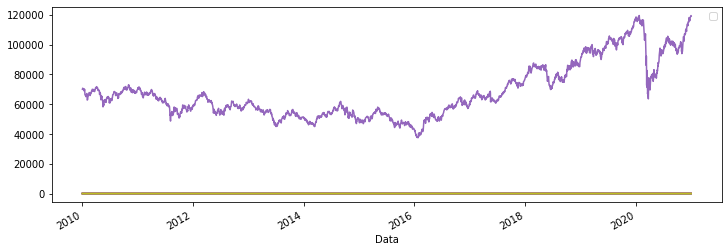

<Figure size 1152x576 with 0 Axes>

In [57]:
#Plotando os valores de fechamento das cotações
dados_analise = dados.xs(key='Close',axis=1,level='Stock Info')

plt.legend()
plt.grid('whitegrid')

for tick in tickers:
  dados_analise[tick].plot(label=tick,figsize=(12,4))
plt.figure(figsize = (16,8))

# Observar que os valores de dados do IBOVESPA estão em uma escala muito maior, necessitando normalização dos dados para observar comportamento

In [58]:
dados_analise_normal = normalize(dados_analise)
dados_analise_normal.head()

Bank Ticker,BBAS,BBDC,ITUB,SANB,IBOV,PETR,VALE,USD,Selic
Data,,,,,,,,,
2010-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2010-01-05,0.989967,0.994695,1.006481,1.009684,1.002784,0.991426,1.009322,1.010471,1.0
2010-01-06,0.991304,0.986737,0.997757,1.004632,1.009765,1.004823,1.030686,1.007272,1.0
2010-01-07,0.991639,0.984085,0.987537,0.997474,1.005796,0.995445,1.034958,1.011576,1.0
2010-01-08,0.997324,0.983024,0.972582,0.987368,1.003112,0.990086,1.045057,1.007563,1.0


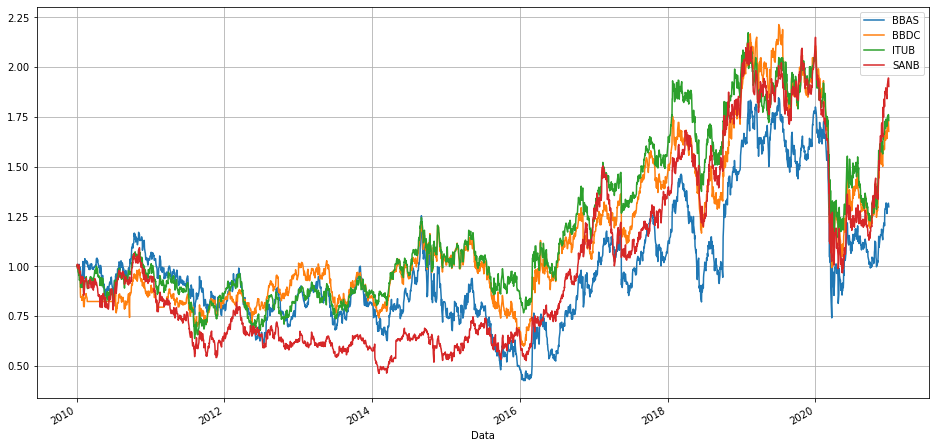

In [59]:
# Plotando o comportamento das ações de Bancos
for tick in tickers[:4]:
  dados_analise_normal[tick].plot(label=tick,figsize=(16,8))
plt.legend()
plt.grid('whitegrid')

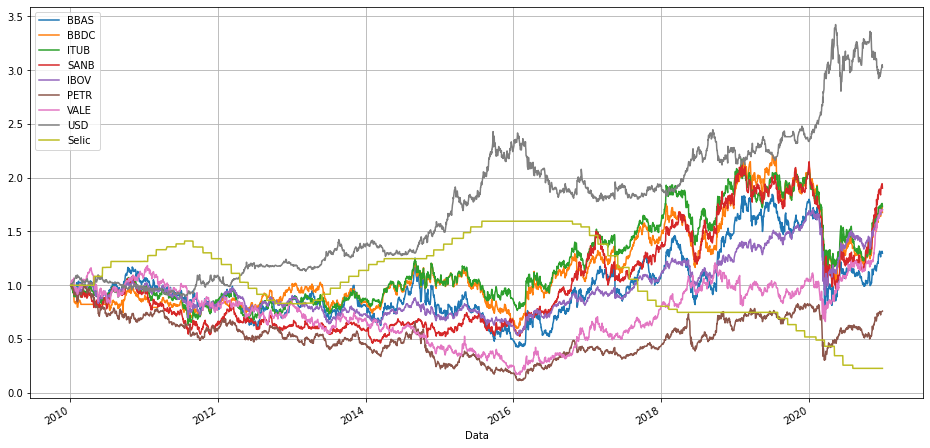

In [60]:
# Plotando comportamento das ações de Bancos e demais ativos
for tick in tickers:
  dados_analise_normal[tick].plot(label=tick,figsize=(16,8))
plt.legend()
plt.grid('whitegrid')

In [61]:
#sns.pairplot(dados_analise_normal)

In [62]:
returns = pd.DataFrame()

In [63]:
for tick in tickers:
  if tick == 'Selic':
    returns[tick+' Return'] = dados_analise[tick]
  else:
    returns[tick+' Return'] = dados_analise[tick].pct_change() * 100

In [64]:
returns.head(20)

,BBAS Return,BBDC Return,ITUB Return,SANB Return,IBOV Return,PETR Return,VALE Return,USD Return,Selic Return
Data,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032927
2010-01-05,-1.003342,-0.530496,0.648057,0.968419,0.278392,-0.857448,0.932219,1.047121,0.032927
2010-01-06,0.135132,-0.800005,-0.866769,-0.500413,0.696185,1.351351,2.116603,-0.316636,0.032927
2010-01-07,0.033739,-0.268813,-1.024227,-0.712490,-0.393050,-0.933329,0.414549,0.427370,0.032927
2010-01-08,0.573356,-0.107816,-1.514394,-1.013085,-0.266852,-0.538360,0.975794,-0.396800,0.032927
2010-01-11,0.771293,0.080948,-0.871344,1.066098,0.241948,-0.324760,-0.297342,-0.057739,0.032927
2010-01-12,-0.831947,0.296573,-0.930714,0.168772,-0.506865,-1.276137,-0.279593,0.363957,0.032927
2010-01-13,1.275171,0.537638,0.313156,0.673967,0.440950,-0.165020,1.233645,0.495021,0.032927
2010-01-14,-1.424786,-2.139034,-1.378781,-2.719664,-0.829722,-1.735540,-0.018461,1.042438,0.032927


In [65]:
# Observar o retorno diário da Selic comparado com as ações. Valores muito próximos, com risco muito menor
returns.describe()


,BBAS Return,BBDC Return,ITUB Return,SANB Return,IBOV Return,PETR Return,VALE Return,USD Return,Selic Return
count,2717.000000,2717.000000,2717.000000,2717.000000,2717.000000,2717.000000,2717.000000,2717.000000,2718.000000
mean,0.044950,0.042704,0.040431,0.049680,0.032357,0.034028,0.055517,0.046552,0.034967
std,2.655558,2.177430,2.012957,2.281935,1.591522,2.956277,2.683015,1.072391,0.012160
min,-21.171174,-14.274426,-12.046662,-13.474025,-14.779679,-29.697769,-24.559217,-6.180833,0.007469
25%,-1.372549,-1.095008,-1.125709,-1.232521,-0.819491,-1.476374,-1.373150,-0.452234,0.024620
50%,0.000000,0.000000,0.000000,0.000000,0.028820,0.000000,0.000000,0.000000,0.036564
75%,1.367988,1.131645,1.100055,1.316286,0.897033,1.424146,1.347777,0.531363,0.043810
max,17.126078,16.866914,11.770349,15.777082,13.908215,22.222215,21.357860,7.518989,0.052531


In [66]:
# Interessante observar que em 2019 o retorno da Selic caiu muito. Por outro lado, o retorno das ações foi positivo
returns_2019 = returns[returns[:].index.year==2019]
returns_2019.describe()

,BBAS Return,BBDC Return,ITUB Return,SANB Return,IBOV Return,PETR Return,VALE Return,USD Return,Selic Return
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,0.070192,0.061049,0.030333,0.069917,0.118739,0.132487,0.051273,0.019265,0.022926
std,1.929002,1.682110,1.583553,1.666210,1.135924,1.834336,2.500129,0.874083,0.002341
min,-6.093324,-5.824995,-4.257996,-4.512467,-3.738137,-7.750000,-24.559217,-2.500598,0.017089
25%,-1.138671,-1.075546,-1.116677,-1.123369,-0.514065,-1.008519,-0.892454,-0.459542,0.020872
50%,0.000000,-0.057940,-0.027172,0.022575,0.204308,0.131625,0.058921,0.000000,0.024620
75%,1.331510,1.179429,1.134147,1.185472,0.867858,1.194724,0.964375,0.394557,0.024620
max,6.155379,5.648923,4.225352,6.570372,3.555702,6.084652,9.031345,3.538944,0.024620


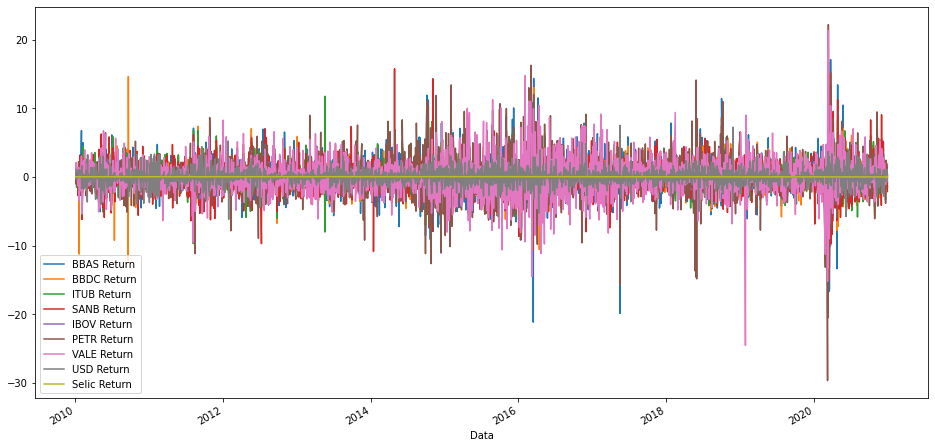

In [67]:
#sns.pairplot(returns)
returns.plot(kind='line',figsize=(16,8))

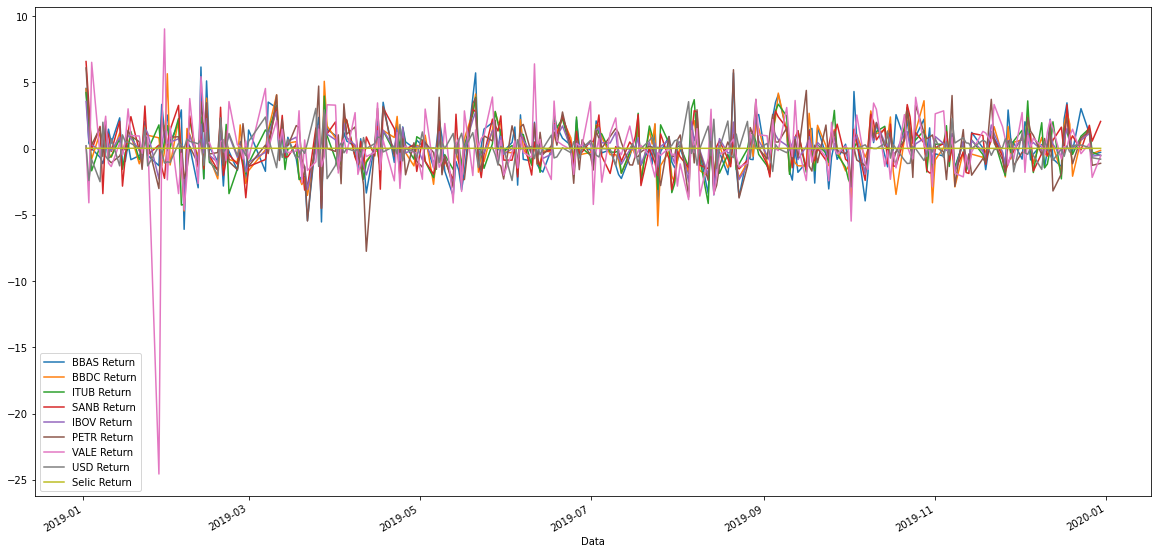

In [68]:
returns_2019.plot(kind='line',figsize=(20,10))

In [69]:
returns.columns
#bank_returns = returns.drop('IBOV Return',axis=1, inplace=True)

Index(['BBAS Return', 'BBDC Return', 'ITUB Return', 'SANB Return',
       'IBOV Return', 'PETR Return', 'VALE Return', 'USD Return',
       'Selic Return'],
      dtype='object')

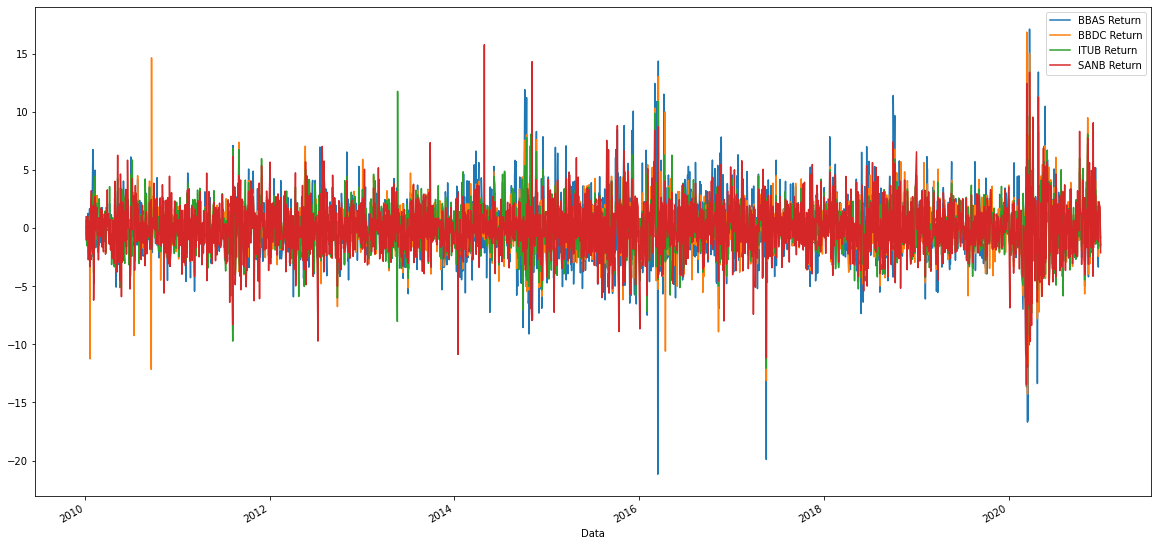

In [70]:
bank_returns = pd.DataFrame()
bank_returns = returns.drop('IBOV Return',axis=1, inplace=False)
bank_returns = bank_returns.drop('PETR Return',axis=1, inplace=False)
bank_returns = bank_returns.drop('VALE Return',axis=1, inplace=False)
bank_returns = bank_returns.drop('USD Return',axis=1, inplace=False)
bank_returns = bank_returns.drop('Selic Return',axis=1, inplace=False)
bank_returns.plot(kind='line',figsize=(20,10))

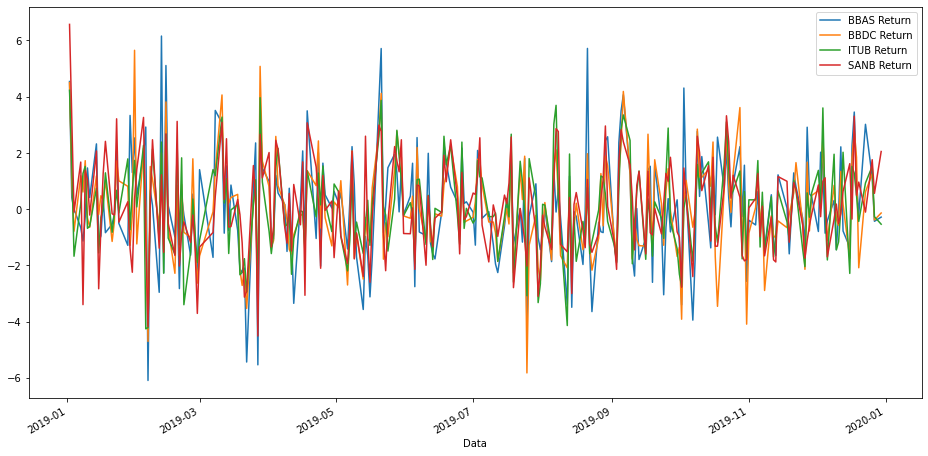

In [71]:
bank_returns_2019 = pd.DataFrame()
bank_returns_2019 = returns_2019.drop('IBOV Return',axis=1, inplace=False)
bank_returns_2019 = bank_returns_2019.drop('PETR Return',axis=1, inplace=False)
bank_returns_2019 = bank_returns_2019.drop('VALE Return',axis=1, inplace=False)
bank_returns_2019 = bank_returns_2019.drop('USD Return',axis=1, inplace=False)
bank_returns_2019 = bank_returns_2019.drop('Selic Return',axis=1, inplace=False)
bank_returns_2019.plot(kind='line',figsize=(16,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1864a4a110>,
      dtype=object)

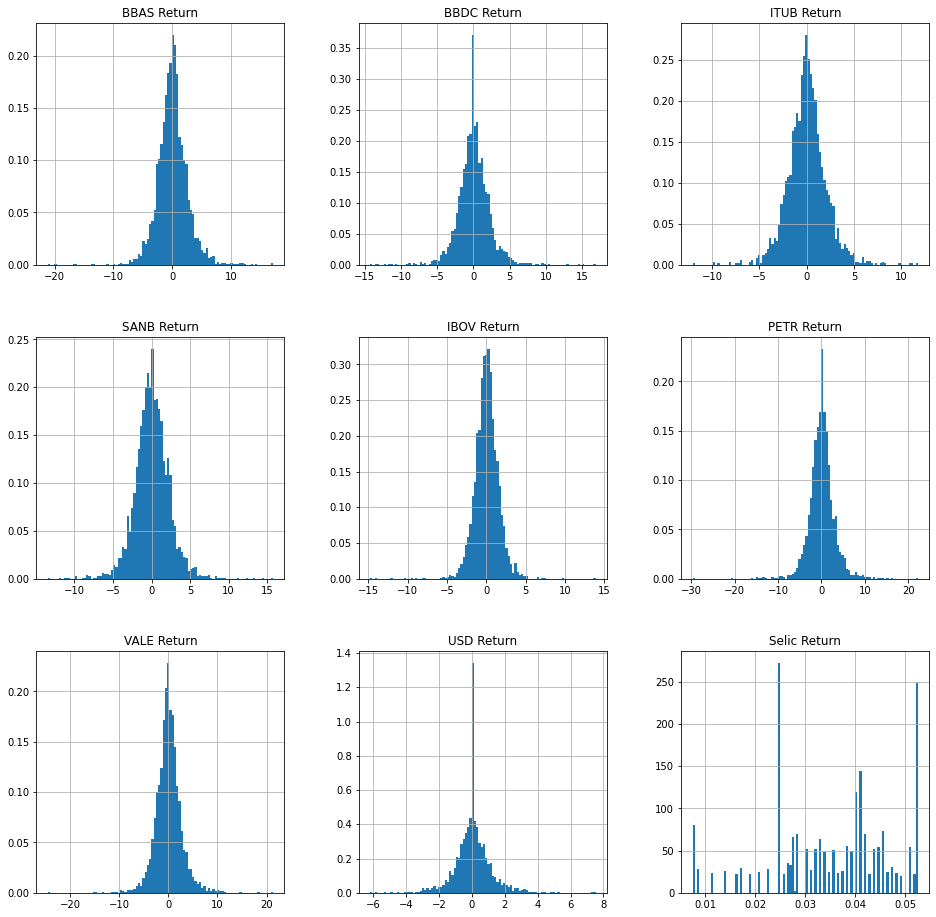

In [72]:
returns.hist(figsize=(16,16),bins=100, density=True)

### 11. Iniciando dados para Machine Learning - Ação, Split, etc

### 11.1 - Definição de Variáveis

In [73]:
#Definindo a ação que será rodada a modelagem
stock_ticker_id = 'BBDC'

In [74]:
#Definindo o período de dias para o alvo da modelagem
# forecast_target = 1 -> predição para dia seguinte
# forecast_target = 2 -> predição para dia seguinte
# forecast_target = 5 -> predição para 5 dias úteis (aprox. 1 semana)
# forecast_target = 7 -> predição para 7 dias úteis (média móvel 7 dias)
# forecast_target = 14 -> predição para 14 dias úteis (média móvel 14 dias)
# forecast_target = 30 -> predição para 30 dias úteis
# forecast_target = 60 -> predição para 60 dias úteis
# forecast_target = 120 -> predição para 90 dias úteis
forecast_target = 1

In [75]:
#DEFINIÇÕES DE JANELA DE PREDIÇÃO E SPLIT
#Janela de predição (30, 60, 90 dias)
#predict_window = 90

#Definindo o split
#split = len(dados)-predict_window-1 # incluído o valor de -1 devido ao índice iniciar em zero

In [76]:
#### OUTRAS DEFINIÇÕES DE SPLIT e PREDICT_WINDOW


#Definindo o Split para incluir dados de treinamento até 2018 e testes para 2019 e 2020
split = int(len(dados[dados.index.year < 2019]))

#Definindo o Split para incluir dados de treinamento até 2019 e testes para 2020
#split = int(len(dados[dados.index.year < 2020]))

#Definindo o Split para o último ano
#split = int(len(dados[dados.index < datetime(now.year-1,now.month,now.day)]))

predict_window = len(dados)-split-1

split/len(dados)

0.8182487122884474

In [77]:
#Criando o DataFrame para armazenar os scores das modelagens
df_model_scores = pd.DataFrame()
df_model_scores_best = pd.DataFrame()

In [78]:
predict_window

493

### 11.2 - Definição das Features

In [79]:
dados.head()

Bank Ticker       BBAS                        ...       VALE     USD     Selic
Stock Info        High        Low       Open  ...  Adj Close   Close     Close
Data                                          ...                             
2010-01-04   30.000000  29.700001  29.799999  ...  32.089706  1.7190  0.032927
2010-01-05   30.100000  29.190001  30.100000  ...  32.388855  1.7370  0.032927
2010-01-06   30.000000  29.420000  29.490000  ...  33.074394  1.7315  0.032927
2010-01-07   29.709999  29.410000  29.440001  ...  33.211502  1.7389  0.032927
2010-01-08   29.820000  29.469999  29.700001  ...  33.535576  1.7320  0.032927

[5 rows x 44 columns]

In [80]:
#Definindo as features que serão modeladas (Cotação e Volume)
#Definindo também a ação que será modelada (stock_ticker_id)
bank_price_features_df = individual_stock_all_features(dados,stock_ticker_id)
bank_price_features_target_df = trading_window(bank_price_features_df,forecast_target)
bank_price_features_target_df = bank_price_features_target_df[:-forecast_target]
bank_price_features_target_df.tail(forecast_target+5)

,Close,Volume,Selic,Dolar,Return,EMAClose,EMAOpen,EMAHigh,EMALow,RSI,WILLR,MACD,MACDsignal,MACDhist,OBV,ROC,fastk,fastd,Target
Data,,,,,,,,,,,,,,,,,,,
2020-12-18,27.219999,44708400.0,0.007469,5.056900,0.184024,26.769575,26.701784,27.176399,26.472288,92.273616,-15.315701,0.956563,0.952390,0.004173,2.517842e+09,8.544508,100.000000,100.000000,26.559999
2020-12-21,26.559999,54976600.0,0.007469,5.100600,-2.424687,26.717181,26.676338,27.154799,26.486716,90.072504,-18.926746,0.944848,0.950881,-0.006034,2.462865e+09,7.247407,0.000000,66.666667,27.100000
2020-12-22,27.100000,31840600.0,0.007469,5.118938,2.033136,26.812886,26.697254,27.178599,26.555037,90.517470,-16.355572,0.932536,0.947212,-0.014676,2.494706e+09,6.553426,20.215537,40.071846,27.719999
2020-12-23,27.719999,26350200.0,0.007469,5.156655,2.287819,27.039664,26.852940,27.358949,26.706278,91.490737,-13.945551,0.930354,0.943841,-0.013487,2.521056e+09,7.012145,64.432592,28.216043,27.990000
2020-12-28,27.990000,37557800.0,0.007469,5.215300,0.974028,27.277248,27.164705,27.584212,27.009708,92.373844,-12.792115,0.936995,0.942472,-0.005477,2.558614e+09,7.387001,100.000000,61.549376,27.530001
2020-12-29,27.530001,22192700.0,0.007469,5.245900,-1.643441,27.340436,27.328529,27.658159,27.099782,92.593990,-13.323237,0.936560,0.941289,-0.004729,2.580807e+09,7.036220,100.000000,88.144197,27.139999


In [81]:
#bank_price_features_target_df_2016 = bank_price_features_target_df[bank_price_features_target_df.index.year > 2016]
#sns.pairplot(bank_price_features_target_df_2016)

### 12. LINEAR REGRESSION - Variáveis Iniciais

In [82]:
from sklearn.linear_model import LinearRegression

In [83]:
# Definir as variáveis para escolha das melhores features e melhores modelos
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy = 0
best_model_lr = 'All'

### 12.1 - LINEAR REGRESSION - Loop para encontrar melhor modelo e features

In [84]:
# Definir as variáveis para escolha das melhores features e melhores modelos
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy = 0
best_model_lr = 'All'

for i in Lista:
  if i == 'Cot':
    bank_price_features_df_lr = individual_stock_close(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Cot e Vol':
    bank_price_features_df_lr = individual_stock_close_volume(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Cot Vol e Dolar':
    bank_price_features_df_lr = individual_stock_close_volume_dolar(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Cot Vol Selic e Dolar':
    bank_price_features_df_lr = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Tech':
    bank_price_features_df_lr = individual_stock_technical_features(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'TechAll':
    bank_price_features_df_lr = individual_stock_tech_all_features(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'All':
    bank_price_features_df_lr = individual_stock_all_features(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  else:
    print('Error')
  
  bank_price_features_target_df_lr = trading_window(bank_price_features_df_lr,forecast_target)
  bank_price_features_target_df_lr = bank_price_features_target_df_lr[:-forecast_target]

  # Criar o valor de X com todas as features
  # Criar o valor de y com os valores do target
  X = np.array(bank_price_features_target_df_lr.drop(['Target'],axis=1))
  y = bank_price_features_target_df_lr['Target'].values

  # Definindo os X_Train, X_test, y_train e y_test
  X_train = X[:split]
  X_test = X[split:]
  y_train = y[:split]
  y_test = y[split:]
  
  # Instanciando o objeto
  linear_regression = LinearRegression( )

  
  print(bank_price_features_target_df_lr.tail())
  # Treinando o modelo 
  linear_regression.fit(X_train, y_train)

  # Valor do intercepto
  #print(linear_regression.intercept_)

  # Valor dos Coeficientes
  #linear_regression.coef_
  #list(zip(bank_price_features_target_df.columns, abs(linear_regression.coef_)))

  # Realizar predições com o modelo de Regressão Linear
  predicted_prices_lr = linear_regression.predict(X_test)

  # Imprime os scores para o modelo
  #print_model_scores("Linear Regression - "+str(i),y_test,predicted_prices_lr)

  # Armazena os valores dos modelos
  df_model_scores = assign_model_scores('Linear Regression - '+str(i),y_test,predicted_prices_lr,stock_ticker_id,df_model_scores)

  current_accuracy = r2_score(y_test,predicted_prices_lr)

  # salvar o melhor modelo para uso posterior
  if current_accuracy > best_accuracy:
    best_accuracy = current_accuracy
    best_model_lr = i

#print(bank_price_features_df_lr.head())
print(df_model_scores.tail(len(Lista)))
print('\n')
print('Linear Regression best model: '+str(best_model_lr))


                Close     Target
Data                            
2020-12-21  26.559999  27.100000
2020-12-22  27.100000  27.719999
2020-12-23  27.719999  27.990000
2020-12-28  27.990000  27.530001
2020-12-29  27.530001  27.139999
                Close      Volume     Target
Data                                        
2020-12-21  26.559999  54976600.0  27.100000
2020-12-22  27.100000  31840600.0  27.719999
2020-12-23  27.719999  26350200.0  27.990000
2020-12-28  27.990000  37557800.0  27.530001
2020-12-29  27.530001  22192700.0  27.139999
                Close      Volume     Dolar     Target
Data                                                  
2020-12-21  26.559999  54976600.0  5.100600  27.100000
2020-12-22  27.100000  31840600.0  5.118938  27.719999
2020-12-23  27.719999  26350200.0  5.156655  27.990000
2020-12-28  27.990000  37557800.0  5.215300  27.530001
2020-12-29  27.530001  22192700.0  5.245900  27.139999
                Close      Volume     Selic     Dolar     Target
Data

### 12.2 - Regressão Linear - Aplicando Melhor Modelo

In [85]:
if best_model_lr == 'Cot':
  bank_price_features_df_best = individual_stock_close(dados,stock_ticker_id)
  #print(i)
  #print(bank_price_features_df.columns)
elif best_model_lr == 'Cot e Vol':
  bank_price_features_df_best = individual_stock_close_volume(dados,stock_ticker_id)
  #print(i)
  #print(bank_price_features_df.columns)
elif best_model_lr == 'Cot Vol e Dolar':
  bank_price_features_df_best = individual_stock_close_volume_dolar(dados,stock_ticker_id)
  #print(i)
  #print(bank_price_features_df.columns)
elif best_model_lr == 'Cot Vol Selic e Dolar':
  bank_price_features_df_best = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
  #print(i)
  #print(bank_price_features_df.columns)
elif best_model_lr == 'Tech':
  bank_price_features_df_best = individual_stock_technical_features(dados,stock_ticker_id)
  #print(i)
  #print(bank_price_features_df.columns)
elif best_model_lr == 'TechAll':
  bank_price_features_df_best = individual_stock_tech_all_features(dados,stock_ticker_id)
  #print(i)
  #print(bank_price_features_df.columns)
elif best_model_lr == 'All':
  bank_price_features_df_best = individual_stock_all_features(dados,stock_ticker_id)
  #print(i)
  #print(bank_price_features_df.columns)
else:
  print('Error')
  
bank_price_features_target_df_best = trading_window(bank_price_features_df_best,forecast_target)
bank_price_features_target_df_best = bank_price_features_target_df_best[:-forecast_target]

print('Best Model: '+str(best_model_lr))
print('\n')
print(bank_price_features_target_df_best.tail(forecast_target+5))

Best Model: TechAll


                Close   EMAClose    EMAOpen  ...       fastk       fastd     Target
Data                                         ...                                   
2020-12-18  27.219999  26.769575  26.701784  ...  100.000000  100.000000  26.559999
2020-12-21  26.559999  26.717181  26.676338  ...    0.000000   66.666667  27.100000
2020-12-22  27.100000  26.812886  26.697254  ...   20.215537   40.071846  27.719999
2020-12-23  27.719999  27.039664  26.852940  ...   64.432592   28.216043  27.990000
2020-12-28  27.990000  27.277248  27.164705  ...  100.000000   61.549376  27.530001
2020-12-29  27.530001  27.340436  27.328529  ...  100.000000   88.144197  27.139999

[6 rows x 15 columns]


In [86]:
  # Criar o valor de X com todas as features
  # Criar o valor de y com os valores do target
  X = np.array(bank_price_features_target_df_best.drop(['Target'],axis=1))
  y = bank_price_features_target_df_best['Target'].values

  # Definindo os X_Train, X_test, y_train e y_test
  X_train = X[:split]
  X_test = X[split:]
  y_train = y[:split]
  y_test = y[split:]

In [87]:
# Instanciando o objeto
linear_regression = LinearRegression( )

# Treinando o modelo 
linear_regression.fit(X_train, y_train)

#Testando o Modelo e Sua Acurácia
#lr_accuracy = linear_regression.score(X_test, y_test)
#print("Linear Regression Score: ", lr_accuracy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
# Valor do intercepto
linear_regression.intercept_

-0.08138112583241863

In [89]:
# Valor dos Coeficientes
#linear_regression.coef_
list(zip(bank_price_features_target_df_best.columns, abs(linear_regression.coef_)))

[('Close', 0.9098308859858352),
 ('EMAClose', 0.0371613036161105),
 ('EMAOpen', 0.04442733858394193),
 ('EMAHigh', 0.029787298638085425),
 ('EMALow', 0.04079554149075868),
 ('RSI', 0.0005684073604633762),
 ('WILLR', 0.0005368382066627818),
 ('MACD', 0.007329716652730964),
 ('MACDsignal', 0.018912258838349818),
 ('MACDhist', 0.011582542185618466),
 ('OBV', 1.5030067468391195e-11),
 ('ROC', 0.004112598305440703),
 ('fastk', 0.0004232479759077537),
 ('fastd', 0.0002133242139022959)]

In [90]:
# Realizar predições com o modelo de Regressão Linear
predicted_prices_lr = linear_regression.predict(X_test)

In [91]:
print_model_scores("Linear Regression - "+str(best_model_lr),y_test,predicted_prices_lr)

Linear Regression - TechAll - R2 Score:  0.9855514881233871


Linear Regression - TechAll - MAE:  0.4864423476493987
Linear Regression - TechAll - MSE:  0.43566618314966127
Linear Regression - TechAll - RMSE:  0.6600501368454227


In [92]:
  # Armazena os valores dos modelos
  df_model_scores_best = assign_model_scores("Linear Regression - "+str(best_model_lr),y_test,predicted_prices_lr,stock_ticker_id,df_model_scores_best)

In [93]:
# Criar um dataframe baseado nas datas e nos valores individuais das ações
df_predicted_lr_best = pd.DataFrame(bank_price_features_df_best[split+forecast_target:].index)
df_predicted_lr_best['Target Close'] = pd.DataFrame(y_test)
df_predicted_lr_best['Prediction'] = pd.DataFrame(predicted_prices_lr)
df_predicted_lr_best.head()

,Data,Target Close,Prediction
0,2019-01-03,30.893938,30.450805
1,2019-01-04,30.651514,30.766515
2,2019-01-07,31.015150,30.578263
3,2019-01-08,31.204544,30.939910
4,2019-01-09,31.742424,31.137355


In [94]:
interactive_plot(df_predicted_lr_best,stock_ticker_id+' - Fechamento x Predição')

In [95]:
# Definindo a data como índice
df_predicted_lr_best.set_index('Data',inplace=True)

In [96]:
plot_data_train_test_prediction(dados,df_predicted_lr_best,stock_ticker_id,split,forecast_target)

### 13. RIDGE LINEAR REGRESSION MODEL - Variáveis Iniciais

In [97]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler

In [98]:
# Definir as variáveis para escolha das melhores features e melhores modelos
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy = 0
best_model_ridge = 'All'
alpha_ridge = 2

In [99]:
#Definindo a ação que será rodada a regressão
#stock_ticker_id = 'BBAS'

In [100]:
#Definindo o percentual do Split (65%)
#split = int(0.65 * len(X))

#Definindo o percentual do Split (75%)
#split = int(0.75 * len(X))

#Definindo o Split para incluir dados de treinamento até 2018 e testes para 2019 e 2020
#split = int(len(dados[dados.index.year < 2019]))
#split/len(dados)

In [101]:
#Definindo o valor de alpha para o modelo (0, 1, 2)
# Valor 0 =====>>>> LINEAR REGRESSION
# Valor >0 ======>>>>> RIDGE REGRESSION
# best_alpha = 0

### 13.1 - RIDGE REGRESSION MODEL - Loop para encontrar melhor modelo e features

In [102]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy = 0
best_model_ridge = 'All'
alpha_ridge = 5

for i in Lista:
  if i == 'Cot':
    bank_price_features_df_ridge = individual_stock_close(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Cot e Vol':
    bank_price_features_df_ridge = individual_stock_close_volume(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Cot Vol e Dolar':
    bank_price_features_df_ridge = individual_stock_close_volume_dolar(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Cot Vol Selic e Dolar':
    bank_price_features_df_ridge = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Tech':
    bank_price_features_df_ridge = individual_stock_technical_features(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'TechAll':
    bank_price_features_df_ridge = individual_stock_tech_all_features(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'All':
    bank_price_features_df_ridge = individual_stock_all_features(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  else:
    print('Error')
  
  bank_price_features_target_df_ridge = trading_window(bank_price_features_df_ridge,forecast_target)
  bank_price_features_target_df_ridge = bank_price_features_target_df_ridge[:-forecast_target]

  # Criar o valor de X com todas as features
  # Criar o valor de y com os valores do target
  X = np.array(bank_price_features_target_df_ridge.drop(['Target'],axis=1))
  y = bank_price_features_target_df_ridge['Target'].values

  # Definindo os X_Train, X_test, y_train e y_test
  X_train = X[:split]
  X_test = X[split:]
  y_train = y[:split]
  y_test = y[split:]
  
  # Instanciando o objeto
  ridge_regression = Ridge(alpha=alpha_ridge)

  # Treinando o modelo 
  ridge_regression.fit(X_train, y_train)

  # Realizar predições com o modelo de Regressão Linear
  predicted_prices_ridge = ridge_regression.predict(X_test)

  # Armazena os valores dos modelos
  df_model_scores = assign_model_scores("Ridge Regression - "+str(i),y_test,predicted_prices_ridge,stock_ticker_id,df_model_scores)

  # Criar um dataframe baseado nas datas e nos valores individuais das ações
  #df_predicted_ridge = pd.DataFrame(bank_price_features_df_ridge[split+forecast_target:].index)
  #df_predicted_ridge['Target Close'] = pd.DataFrame(y_test)
  #df_predicted_ridge['Prediction'] = pd.DataFrame(predicted_prices_ridge)

  current_accuracy = r2_score(y_test,predicted_prices_ridge)

  # salvar o melhor modelo para uso posterior
  if current_accuracy > best_accuracy:
    best_accuracy = current_accuracy
    best_model_ridge = i

#print(bank_price_features_df_lr.head())
print(df_model_scores.tail(len(Lista)))
print('\n')
print('Ridge Regression best model: '+str(best_model_ridge))
print('\n')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=3.12569e-17): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=8.79223e-21): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=8.3843e-21): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=8.39006e-21): result may not be accurate.



                                  1 - Metric  ...  5 - BBDC - RMSE
7                     Ridge Regression - Cot  ...         0.661636
8               Ridge Regression - Cot e Vol  ...         0.662128
9         Ridge Regression - Cot Vol e Dolar  ...         0.661595
10  Ridge Regression - Cot Vol Selic e Dolar  ...         0.661625
11                   Ridge Regression - Tech  ...         0.661032
12                Ridge Regression - TechAll  ...         0.660221
13                    Ridge Regression - All  ...         0.661268

[7 rows x 5 columns]


Ridge Regression best model: TechAll




### 13.2 - RIDGE LINEAR REGRESSION - Aplicando Melhor Modelo

In [103]:
if best_model_ridge == 'Cot':
  bank_price_features_df_ridge_best = individual_stock_close(dados,stock_ticker_id)
elif best_model_ridge == 'Cot e Vol':
  bank_price_features_df_ridge_best = individual_stock_close_volume(dados,stock_ticker_id)
elif best_model_ridge == 'Cot Vol e Dolar':
  bank_price_features_df_ridge_best = individual_stock_close_volume_dolar(dados,stock_ticker_id)
elif best_model_ridge == 'Cot Vol Selic e Dolar':
  bank_price_features_df_ridge_best = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
elif best_model_ridge == 'Tech':
  bank_price_features_df_ridge_best = individual_stock_technical_features(dados,stock_ticker_id)
elif best_model_ridge == 'TechAll':
  bank_price_features_df_ridge_best = individual_stock_tech_all_features(dados,stock_ticker_id)
elif best_model_ridge == 'All':
  bank_price_features_df_ridge_best = individual_stock_all_features(dados,stock_ticker_id)
else:
  print('Error')
  
bank_price_features_target_df_ridge_best = trading_window(bank_price_features_df_ridge_best,forecast_target)
bank_price_features_target_df_ridge_best = bank_price_features_target_df_ridge_best[:-forecast_target]

print('Best Model: '+str(best_model_ridge))
print('\n')
print(bank_price_features_target_df_ridge_best.tail(forecast_target+5))

Best Model: TechAll


                Close   EMAClose    EMAOpen  ...       fastk       fastd     Target
Data                                         ...                                   
2020-12-18  27.219999  26.769575  26.701784  ...  100.000000  100.000000  26.559999
2020-12-21  26.559999  26.717181  26.676338  ...    0.000000   66.666667  27.100000
2020-12-22  27.100000  26.812886  26.697254  ...   20.215537   40.071846  27.719999
2020-12-23  27.719999  27.039664  26.852940  ...   64.432592   28.216043  27.990000
2020-12-28  27.990000  27.277248  27.164705  ...  100.000000   61.549376  27.530001
2020-12-29  27.530001  27.340436  27.328529  ...  100.000000   88.144197  27.139999

[6 rows x 15 columns]


In [104]:
# Criar o valor de X com todas as features
# Criar o valor de y com os valores do target
X = np.array(bank_price_features_target_df_ridge_best.drop(['Target'],axis=1))
y = bank_price_features_target_df_ridge_best['Target'].values

# Definindo os X_Train, X_test, y_train e y_test
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [105]:
# Instanciando o objeto
ridge_regression = Ridge(alpha=alpha_ridge)

# Treinando o modelo 
ridge_regression.fit(X_train, y_train)

# Realizar predições com o modelo de Regressão Linear
predicted_prices_ridge = ridge_regression.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=8.3843e-21): result may not be accurate.



In [106]:
# Valor do intercepto
ridge_regression.intercept_

-0.08723747567606921

In [107]:
# Valor dos Coeficientes
#linear_regression.coef_
list(zip(bank_price_features_target_df_ridge_best.columns, abs(ridge_regression.coef_)))

[('Close', 0.8751294335380791),
 ('EMAClose', 0.08524424637992291),
 ('EMAOpen', 0.0015892642291958374),
 ('EMAHigh', 0.012487077932651728),
 ('EMALow', 0.05628236815357869),
 ('RSI', 0.0005529729592057842),
 ('WILLR', 0.0005209564279604611),
 ('MACD', 0.011172657284061296),
 ('MACDsignal', 0.017144429944479775),
 ('MACDhist', 0.005971772660435243),
 ('OBV', 1.5900847208784745e-11),
 ('ROC', 0.004804810728993972),
 ('fastk', 0.0006064506665251385),
 ('fastd', 0.00029480103555637737)]

In [108]:
# Criar um dataframe baseado nas datas e nos valores individuais das ações
df_predicted_ridge_best = pd.DataFrame(bank_price_features_df_ridge_best[split+forecast_target:].index)
df_predicted_ridge_best['Target Close'] = pd.DataFrame(y_test)
df_predicted_ridge_best['Prediction'] = pd.DataFrame(predicted_prices_ridge)

In [109]:
print_model_scores('Ridge Regression Model: '+str(best_model_ridge),y_test,predicted_prices_ridge)

Ridge Regression Model: TechAll - R2 Score:  0.9855439950099555


Ridge Regression Model: TechAll - MAE:  0.48697470801843773
Ridge Regression Model: TechAll - MSE:  0.4358921231050352
Ridge Regression Model: TechAll - RMSE:  0.6602212682919532


In [110]:
# Armazena os valores dos modelos
df_model_scores_best = assign_model_scores('Ridge Regression Model: '+str(best_model_ridge),y_test,predicted_prices_ridge,stock_ticker_id,df_model_scores_best)

In [111]:
interactive_plot(df_predicted_ridge_best,'Original x Predição')

In [112]:
# Definindo a data como índice
df_predicted_ridge_best.set_index('Data',inplace=True)

In [113]:
plot_data_train_test_prediction(dados,df_predicted_ridge_best,stock_ticker_id,split,forecast_target)

In [114]:
df_model_scores.tail(30)

,1 - Metric,2 - BBDC - R2 Score,3 - BBDC - MAE,4 - BBDC - MSE,5 - BBDC - RMSE
0,Linear Regression - Cot,0.985480,0.484673,0.437828,0.661686
1,Linear Regression - Cot e Vol,0.985458,0.485070,0.438493,0.662188
2,Linear Regression - Cot Vol e Dolar,0.985481,0.484927,0.437784,0.661653
3,Linear Regression - Cot Vol Selic e Dolar,0.985350,0.488862,0.441751,0.664643
4,Linear Regression - Tech,0.985506,0.485543,0.437039,0.661089
5,Linear Regression - TechAll,0.985551,0.486442,0.435666,0.660050
6,Linear Regression - All,0.985134,0.500559,0.448268,0.669528
7,Ridge Regression - Cot,0.985482,0.484622,0.437762,0.661636
8,Ridge Regression - Cot e Vol,0.985460,0.485010,0.438414,0.662128
9,Ridge Regression - Cot Vol e Dolar,0.985484,0.484863,0.437707,0.661595


### 14. LASSO (Least Absolute Shrinkage And Selection Operator regularization) - Variáveis Iniciais

In [115]:
from sklearn.linear_model import Lasso

In [116]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy = 0
alpha_lasso = 0.8
best_model_lasso = 'All'

### 14.1 - LASSO - Loop para encontrar melhor modelo e features

In [117]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy = 0
alpha_lasso = 0.8
best_model_lasso = 'All'

for i in Lista:
  if i == 'Cot':
    bank_price_features_df_lasso = individual_stock_close(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Cot e Vol':
    bank_price_features_df_lasso = individual_stock_close_volume(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Cot Vol e Dolar':
    bank_price_features_df_lasso = individual_stock_close_volume_dolar(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Cot Vol Selic e Dolar':
    bank_price_features_df_lasso = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'Tech':
    bank_price_features_df_lasso = individual_stock_technical_features(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'TechAll':
    bank_price_features_df_lasso = individual_stock_tech_all_features(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  elif i == 'All':
    bank_price_features_df_lasso = individual_stock_all_features(dados,stock_ticker_id)
    #print(i)
    #print(bank_price_features_df.columns)
  else:
    print('Error')
  
  bank_price_features_target_df_lasso = trading_window(bank_price_features_df_lasso,forecast_target)
  bank_price_features_target_df_lasso = bank_price_features_target_df_lasso[:-forecast_target]

  # Criar o valor de X com todas as features
  # Criar o valor de y com os valores do target
  X = np.array(bank_price_features_target_df_lasso.drop(['Target'],axis=1))
  y = bank_price_features_target_df_lasso['Target'].values

  # Definindo os X_Train, X_test, y_train e y_test
  X_train = X[:split]
  X_test = X[split:]
  y_train = y[:split]
  y_test = y[split:]
  
  #instanciar o modelo
  lasso = Lasso(alpha = alpha_lasso, max_iter=100000)

  #treinar o modelo
  lasso.fit(X_train, y_train)

  # Valor do intercepto
  #print(lasso.intercept_)

  # Valor dos Coeficientes
  #list(zip(bank_price_features_target_df_lasso.columns, abs(lasso.coef_)))

  # Realizar predições com o modelo Lasso
  predicted_prices_lasso = lasso.predict(X_test)

  # Armazena os valores dos modelos
  df_model_scores = assign_model_scores("LASSO - "+i,y_test,predicted_prices_lasso,stock_ticker_id,df_model_scores)

  current_accuracy = r2_score(y_test,predicted_prices_lasso)

  # salvar o melhor modelo para uso posterior
  if current_accuracy > best_accuracy:
    best_accuracy = current_accuracy
    best_model_lasso = i

#print(bank_price_features_df_lr.head())
print(df_model_scores.tail(len(Lista)))
print('\n')
print('LASSO best model: '+str(best_model_lasso))
print('\n')



                       1 - Metric  ...  5 - BBDC - RMSE
14                    LASSO - Cot  ...         0.868666
15              LASSO - Cot e Vol  ...         0.857844
16        LASSO - Cot Vol e Dolar  ...         0.857844
17  LASSO - Cot Vol Selic e Dolar  ...         0.857844
18                   LASSO - Tech  ...         2.534260
19                LASSO - TechAll  ...         2.534260
20                    LASSO - All  ...         2.734813

[7 rows x 5 columns]


LASSO best model: Cot e Vol




### 14.2 - LASSO - Aplicando Melhor Modelo e Features

In [118]:
#Para testar
#best_model_lasso = 'Tech'
#best_alpha_lasso = 0.2

In [119]:
if best_model_lasso == 'Cot':
  bank_price_features_df_lasso_best = individual_stock_close(dados,stock_ticker_id)
elif best_model_lasso == 'Cot e Vol':
  bank_price_features_df_lasso_best = individual_stock_close_volume(dados,stock_ticker_id)
elif best_model_lasso == 'Cot Vol e Dolar':
  bank_price_features_df_lasso_best = individual_stock_close_volume_dolar(dados,stock_ticker_id)
elif best_model_lasso == 'Cot Vol Selic e Dolar':
  bank_price_features_df_lasso_best = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
elif best_model_lasso == 'Tech':
  bank_price_features_df_lasso_best = individual_stock_technical_features(dados,stock_ticker_id)
elif best_model_lasso == 'TechAll':
  bank_price_features_df_lasso_best = individual_stock_tech_all_features(dados,stock_ticker_id)
elif best_model_lasso == 'All':
  bank_price_features_df_lasso_best = individual_stock_all_features(dados,stock_ticker_id)
else:
  print('Error')
  
bank_price_features_target_df_lasso_best = trading_window(bank_price_features_df_lasso_best,forecast_target)
bank_price_features_target_df_lasso_best = bank_price_features_target_df_lasso_best[:-forecast_target]

print('Best Model: '+str(best_model_lasso))
print('\n')
print(bank_price_features_target_df_lasso_best.tail(forecast_target+5))


Best Model: Cot e Vol


                Close      Volume     Target
Data                                        
2020-12-18  27.219999  44708400.0  26.559999
2020-12-21  26.559999  54976600.0  27.100000
2020-12-22  27.100000  31840600.0  27.719999
2020-12-23  27.719999  26350200.0  27.990000
2020-12-28  27.990000  37557800.0  27.530001
2020-12-29  27.530001  22192700.0  27.139999


In [120]:
# Criar o valor de X com todas as features
# Criar o valor de y com os valores do target
X = np.array(bank_price_features_target_df_lasso_best.drop(['Target'],axis=1))
y = bank_price_features_target_df_lasso_best['Target'].values

# Definindo os X_Train, X_test, y_train e y_test
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [121]:
#instanciar o modelo
lasso = Lasso(alpha = alpha_lasso, max_iter=100000)

#treinar o modelo
lasso.fit(X_train, y_train)

# Valor do intercepto
print('Intercepto: ',lasso.intercept_)

# Valor dos Coeficientes
list(zip(bank_price_features_target_df_lasso.columns, abs(lasso.coef_)))

Intercepto:  0.7613518854231796


[('Close', 0.951486339418048), ('Volume', 3.0097359479811862e-09)]

In [122]:
# Realizar predições com o modelo de Regressão Linear
predicted_prices_lasso = lasso.predict(X_test)

In [123]:
print_model_scores('Lasso Model: '+str(best_model_lasso),y_test,predicted_prices_lasso)

Lasso Model: Cot e Vol - R2 Score:  0.9755946101204664


Lasso Model: Cot e Vol - MAE:  0.6848414970441218
Lasso Model: Cot e Vol - MSE:  0.7358960665219934
Lasso Model: Cot e Vol - RMSE:  0.857843847399976


In [124]:
# Armazena os valores dos modelos
df_model_scores_best = assign_model_scores("LASSO - "+best_model_lasso,y_test,predicted_prices_lasso,stock_ticker_id,df_model_scores_best)

In [125]:
# Criar um dataframe baseado nas datas e nos valores individuais das ações
df_predicted_lasso_best = pd.DataFrame(bank_price_features_df_lasso[split+forecast_target:].index)
df_predicted_lasso_best['Target Close'] = pd.DataFrame(y_test)
df_predicted_lasso_best['Prediction'] = pd.DataFrame(predicted_prices_lasso)

In [126]:
interactive_plot(df_predicted_lasso_best,'Original x Predição')

In [127]:
# Definindo a data como índice
df_predicted_lasso_best.set_index('Data',inplace=True)

In [128]:
plot_data_train_test_prediction(dados,df_predicted_lasso_best,stock_ticker_id,split,forecast_target)

### 15. ELASTIC NET - Variáveis iniciais

In [129]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV

In [130]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy = 0
alpha_elastic = 0.99
best_model_elastic = 'All'

### 15.1 - ELASTIC NET - Loop para encontrar melhor modelo e features

In [131]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy = 0
alpha_elastic = 0.99
best_model_elastic = 'All'

for i in Lista:
  if i == 'Cot':
    bank_price_features_df_elastic = individual_stock_close(dados,stock_ticker_id)
    #print(bank_price_features_df.columns)
  elif i == 'Cot e Vol':
    bank_price_features_df_elastic = individual_stock_close_volume(dados,stock_ticker_id)
    #print(bank_price_features_df.columns)
  elif i == 'Cot Vol e Dolar':
    bank_price_features_df_elastic = individual_stock_close_volume_dolar(dados,stock_ticker_id)
    #print(bank_price_features_df.columns)
  elif i == 'Cot Vol Selic e Dolar':
    bank_price_features_df_elastic = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
    #print(bank_price_features_df.columns)
  elif i == 'Tech':
    bank_price_features_df_elastic = individual_stock_technical_features(dados,stock_ticker_id)
    #print(bank_price_features_df.columns)
  elif i == 'TechAll':
    bank_price_features_df_elastic = individual_stock_tech_all_features(dados,stock_ticker_id)
    #print(bank_price_features_df.columns)
  elif i == 'All':
    bank_price_features_df_elastic = individual_stock_all_features(dados,stock_ticker_id)
    #print(bank_price_features_df.columns)
    #print(i)
  else:
    print('Error')
  
  bank_price_features_target_df_elastic = trading_window(bank_price_features_df_elastic,forecast_target)
  bank_price_features_target_df_elastic = bank_price_features_target_df_elastic[:-forecast_target]

  # Criar o valor de X com todas as features
  # Criar o valor de y com os valores do target
  X = np.array(bank_price_features_target_df_elastic.drop(['Target'],axis=1))
  y = bank_price_features_target_df_elastic['Target'].values

  # Definindo os X_Train, X_test, y_train e y_test
  X_train = X[:split]
  X_test = X[split:]
  y_train = y[:split]
  y_test = y[split:]
  
  # Instancia o objeto
  en = ElasticNet(alpha = alpha_elastic,l1_ratio=0.01,max_iter=1000000)

  #Treina o modelo      
  en.fit(X_train, y_train)

  # Valor do intercepto
  #print(search.intercept_)

  # Valor dos Coeficientes
  #list(zip(bank_price_features_target_df_elastic.columns, abs(search.coef_)))

  # Realizar predições com o modelo Elastic
  predicted_prices_elastic = en.predict(X_test)

  # Armazena os valores dos modelos
  df_model_scores = assign_model_scores("Elastic Net - "+str(i),y_test,predicted_prices_elastic,stock_ticker_id,df_model_scores)

  current_accuracy = r2_score(y_test,predicted_prices_elastic)

  # salvar o melhor modelo para uso posterior
  if current_accuracy > best_accuracy:
    best_accuracy = current_accuracy
    best_model_elastic = i

#print(bank_price_features_df_lr.head())
#print(df_model_scores.tail(len(Lista)*len(alpha_list_elastic)))
print('\n')
print('Elastic Net best model: '+str(best_model_elastic))
print('\n')




Elastic Net best model: Cot e Vol




### 15.2 - ELASTIC NET - Aplicando Melhor Modelo e Features

In [132]:
#Para testar
#best_model_elastic = 'Tech'
#best_alpha_elastic = 0.001

In [133]:
if best_model_elastic == 'Cot':
  bank_price_features_df_elastic_best = individual_stock_close(dados,stock_ticker_id)
elif best_model_elastic == 'Cot e Vol':
  bank_price_features_df_elastic_best = individual_stock_close_volume(dados,stock_ticker_id)
elif best_model_elastic == 'Cot Vol e Dolar':
  bank_price_features_df_elastic_best = individual_stock_close_volume_dolar(dados,stock_ticker_id)
elif best_model_elastic == 'Cot Vol Selic e Dolar':
  bank_price_features_df_elastic_best = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
elif best_model_elastic == 'Tech':
  bank_price_features_df_elastic_best = individual_stock_technical_features(dados,stock_ticker_id)
elif best_model_elastic == 'TechAll':
  bank_price_features_df_elastic_best = individual_stock_tech_all_features(dados,stock_ticker_id)
elif best_model_elastic == 'All':
  bank_price_features_df_elastic_best = individual_stock_all_features(dados,stock_ticker_id)
else:
  print('Error')
  
bank_price_features_target_df_elastic_best = trading_window(bank_price_features_df_elastic_best,forecast_target)
bank_price_features_target_df_elastic_best = bank_price_features_target_df_elastic_best[:-forecast_target]

print('Best Model: '+str(best_model_elastic))
print('\n')
print(bank_price_features_target_df_elastic_best.tail(forecast_target+5))

Best Model: Cot e Vol


                Close      Volume     Target
Data                                        
2020-12-18  27.219999  44708400.0  26.559999
2020-12-21  26.559999  54976600.0  27.100000
2020-12-22  27.100000  31840600.0  27.719999
2020-12-23  27.719999  26350200.0  27.990000
2020-12-28  27.990000  37557800.0  27.530001
2020-12-29  27.530001  22192700.0  27.139999


In [134]:
# Criar o valor de X com todas as features
# Criar o valor de y com os valores do target
X = np.array(bank_price_features_target_df_elastic_best.drop(['Target'],axis=1))
y = bank_price_features_target_df_elastic_best['Target'].values

# Definindo os X_Train, X_test, y_train e y_test
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [135]:
# Instancia o objeto
en = ElasticNet(alpha = alpha_elastic,l1_ratio=0.01,max_iter=10000)

#Treina o modelo        
en.fit(X_train, y_train)

ElasticNet(alpha=0.99, copy_X=True, fit_intercept=True, l1_ratio=0.01,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [136]:
# Valor do intercepto
print('Intercepto',en.intercept_)

# Valor dos Coeficientes
list(zip(bank_price_features_target_df_elastic.columns, abs(en.coef_)))

Intercepto 0.8880540496609282


[('Close', 0.9434825526354799), ('Volume', 3.3650182107448064e-09)]

In [137]:
# Realizar predições com o modelo Elastic
predicted_prices_elastic = en.predict(X_test)

In [138]:
print_model_scores('Elastic Net Model: '+str(best_model_elastic),y_test,predicted_prices_elastic)

Elastic Net Model: Cot e Vol - R2 Score:  0.971806479526855


Elastic Net Model: Cot e Vol - MAE:  0.7521670896430981
Elastic Net Model: Cot e Vol - MSE:  0.8501196219362032
Elastic Net Model: Cot e Vol - RMSE:  0.9220193175504531


In [139]:
# Armazena os valores dos modelos
df_model_scores_best = assign_model_scores('Elastic Net Model: '+str(best_model_elastic),y_test,predicted_prices_elastic,stock_ticker_id,df_model_scores_best)

In [140]:
# Criar um dataframe baseado nas datas e nos valores individuais das ações
df_predicted_elastic_best = pd.DataFrame(bank_price_features_df_elastic_best[split+forecast_target:].index)
df_predicted_elastic_best['Target Close'] = pd.DataFrame(y_test)
df_predicted_elastic_best['Prediction'] = pd.DataFrame(predicted_prices_elastic)

In [141]:
interactive_plot(df_predicted_elastic_best,'Original x Predição')

In [142]:
# Definindo a data como índice
df_predicted_elastic_best.set_index('Data',inplace=True)

In [143]:
plot_data_train_test_prediction(dados,df_predicted_elastic_best,stock_ticker_id,split,forecast_target)

In [144]:
df_model_scores_best.tail(10)

,1 - Metric,2 - BBDC - R2 Score,3 - BBDC - MAE,4 - BBDC - MSE,5 - BBDC - RMSE
0,Linear Regression - TechAll,0.985551,0.486442,0.435666,0.660050
1,Ridge Regression Model: TechAll,0.985544,0.486975,0.435892,0.660221
2,LASSO - Cot e Vol,0.975595,0.684841,0.735896,0.857844
3,Elastic Net Model: Cot e Vol,0.971806,0.752167,0.850120,0.922019


### 16. SVM - Suport Vector Machines

In [145]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [146]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy_svm = 0
best_model_svm = 'All'

### 16.1 - SVM - Loop para encontrar melhor modelo e features

In [147]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy_svm = 0
best_model_svm = 'All'

for i in Lista:
  if i == 'Cot':
    bank_price_features_df_svm = individual_stock_close(dados,stock_ticker_id)
  elif i == 'Cot e Vol':
    bank_price_features_df_svm = individual_stock_close_volume(dados,stock_ticker_id)
  elif i == 'Cot Vol e Dolar':
    bank_price_features_df_svm = individual_stock_close_volume_dolar(dados,stock_ticker_id)
  elif i == 'Cot Vol Selic e Dolar':
    bank_price_features_df_svm = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
  elif i == 'Tech':
    bank_price_features_df_svm = individual_stock_technical_features(dados,stock_ticker_id)
  elif i == 'TechAll':
    bank_price_features_df_svm = individual_stock_tech_all_features(dados,stock_ticker_id)
  elif i == 'All':
    bank_price_features_df_svm = individual_stock_all_features(dados,stock_ticker_id)
  else:
    print('Error')
  
  bank_price_features_target_df_svm = trading_window(bank_price_features_df_svm,forecast_target)
  bank_price_features_target_df_svm = bank_price_features_target_df_svm[:-forecast_target]

  # Criar o valor de X com todas as features
  # Criar o valor de y com os valores do target
  X = np.array(bank_price_features_target_df_svm.drop(['Target'],axis=1))
  y = bank_price_features_target_df_svm['Target'].values

  # Definindo os X_Train, X_test, y_train e y_test
  X_train = X[:split]
  X_test = X[split:]
  y_train = y[:split]
  y_test = y[split:]

  #Instanciando o modelo
  svr_rbf = make_pipeline(StandardScaler(), SVR(kernel='rbf',C=1e3, gamma=0.1, epsilon=0.2))

  #Treinando o modelo
  svr_rbf.fit(X_train,y_train)

  # Realizar predições com o modelo Elastic
  predicted_prices_svm = svr_rbf.predict(X_test)

  # Armazena os valores dos modelos
  df_model_scores = assign_model_scores("SVM - SVR - "+str(i),y_test,predicted_prices_svm,stock_ticker_id,df_model_scores)

  current_accuracy = r2_score(y_test,predicted_prices_svm)

  # salvar o melhor modelo para uso posterior
  if current_accuracy > best_accuracy_svm:
    best_accuracy_svm = current_accuracy
    best_model_svm = i
    

#print(bank_price_features_df_lr.head())
print(df_model_scores.tail(len(Lista)))
print('\n')
print('SVM-SVR best model: '+str(best_model_svm))
print('\n')



                           1 - Metric  ...  5 - BBDC - RMSE
28                    SVM - SVR - Cot  ...         0.935830
29              SVM - SVR - Cot e Vol  ...         1.241292
30        SVM - SVR - Cot Vol e Dolar  ...         1.798138
31  SVM - SVR - Cot Vol Selic e Dolar  ...         2.417188
32                   SVM - SVR - Tech  ...         6.231881
33                SVM - SVR - TechAll  ...         8.771900
34                    SVM - SVR - All  ...         8.826178

[7 rows x 5 columns]


SVM-SVR best model: Cot




### 16.2 - SVM - Aplicando Melhor Modelo e Features

In [148]:
#Para testar
#best_model_svm = 'Tech'

In [149]:
if best_model_svm == 'Cot':
  bank_price_features_df_svm_best = individual_stock_close(dados,stock_ticker_id)
elif best_model_svm == 'Cot e Vol':
  bank_price_features_df_svm_best = individual_stock_close_volume(dados,stock_ticker_id)
elif best_model_svm == 'Cot Vol e Dolar':
  bank_price_features_df_svm_best = individual_stock_close_volume_dolar(dados,stock_ticker_id)
elif best_model_svm == 'Cot Vol Selic e Dolar':
  bank_price_features_df_svm_best = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
elif best_model_svm == 'Tech':
  bank_price_features_df_svm_best = individual_stock_technical_features(dados,stock_ticker_id)
elif best_model_svm == 'TechAll':
  bank_price_features_df_svm_best = individual_stock_tech_all_features(dados,stock_ticker_id)
elif best_model_svm == 'All':
  bank_price_features_df_svm_best = individual_stock_all_features(dados,stock_ticker_id)
else:
  print('Error')
  
bank_price_features_target_df_svm_best = trading_window(bank_price_features_df_svm_best,forecast_target)
bank_price_features_target_df_svm_best = bank_price_features_target_df_svm_best[:-forecast_target]

print('SVM - SVR - Best Model: '+str(best_model_svm))
print('\n')
print(bank_price_features_target_df_svm_best.tail(forecast_target+5))

SVM - SVR - Best Model: Cot


                Close     Target
Data                            
2020-12-18  27.219999  26.559999
2020-12-21  26.559999  27.100000
2020-12-22  27.100000  27.719999
2020-12-23  27.719999  27.990000
2020-12-28  27.990000  27.530001
2020-12-29  27.530001  27.139999


In [150]:
# Criar o valor de X com todas as features
# Criar o valor de y com os valores do target
X = np.array(bank_price_features_target_df_svm_best.drop(['Target'],axis=1))
y = bank_price_features_target_df_svm_best['Target'].values

# Definindo os X_Train, X_test, y_train e y_test
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [151]:
  #Instanciando o modelo
  svr_rbf = make_pipeline(StandardScaler(), SVR(kernel='rbf',C=1e3, gamma=0.1, epsilon=0.2))

  #Treinando o modelo
  svr_rbf.fit(X_train,y_train)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma=0.1, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [152]:
# Apresenta os parâmetros do Modelo
svr_rbf.get_params()

{'memory': None,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('svr',
   SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma=0.1,
       kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
 'svr': SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma=0.1,
     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 'svr__C': 1000.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.2,
 'svr__gamma': 0.1,
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False,
 'verbose': False}

In [153]:
# Realizar predições com o modelo Elastic
predicted_prices_svm = svr_rbf.predict(X_test)

In [154]:
print_model_scores('SVM - SVR - Model: '+str(best_model_svm),y_test,predicted_prices_svm)

SVM - SVR - Model: Cot - R2 Score:  0.9709555729628613


SVM - SVR - Model: Cot - MAE:  0.7023078834647918
SVM - SVR - Model: Cot - MSE:  0.8757770196057982
SVM - SVR - Model: Cot - RMSE:  0.9358295889775009


In [155]:
# Armazena os valores dos modelos
df_model_scores_best = assign_model_scores("SVM - SVR - "+str(best_model_svm),y_test,predicted_prices_svm,stock_ticker_id,df_model_scores_best)

In [156]:
# Criar um dataframe baseado nas datas e nos valores individuais das ações
df_predicted_svm_best = pd.DataFrame(bank_price_features_df_svm_best[split+forecast_target:].index)
df_predicted_svm_best['Target Close'] = pd.DataFrame(y_test)
df_predicted_svm_best['Prediction'] = pd.DataFrame(predicted_prices_svm)

In [157]:
interactive_plot(df_predicted_svm_best,'Original x Predição')

In [158]:
# Definindo a data como índice
df_predicted_svm_best.set_index('Data',inplace=True)

In [159]:
plot_data_train_test_prediction(dados,df_predicted_svm_best,stock_ticker_id,split,forecast_target)

In [160]:
df_model_scores_best.tail(10)

,1 - Metric,2 - BBDC - R2 Score,3 - BBDC - MAE,4 - BBDC - MSE,5 - BBDC - RMSE
0,Linear Regression - TechAll,0.985551,0.486442,0.435666,0.660050
1,Ridge Regression Model: TechAll,0.985544,0.486975,0.435892,0.660221
2,LASSO - Cot e Vol,0.975595,0.684841,0.735896,0.857844
3,Elastic Net Model: Cot e Vol,0.971806,0.752167,0.850120,0.922019
4,SVM - SVR - Cot,0.970956,0.702308,0.875777,0.935830


In [161]:
df_model_scores.tail(20)

,1 - Metric,2 - BBDC - R2 Score,3 - BBDC - MAE,4 - BBDC - MSE,5 - BBDC - RMSE
15,LASSO - Cot e Vol,0.975595,0.684841,0.735896,0.857844
16,LASSO - Cot Vol e Dolar,0.975595,0.684841,0.735896,0.857844
17,LASSO - Cot Vol Selic e Dolar,0.975595,0.684841,0.735896,0.857844
18,LASSO - Tech,0.787004,2.255236,6.422474,2.534260
19,LASSO - TechAll,0.787004,2.255236,6.422474,2.534260
20,LASSO - All,0.751958,2.430125,7.479205,2.734813
21,Elastic Net - Cot,0.970964,0.770228,0.875519,0.935692
22,Elastic Net - Cot e Vol,0.971806,0.752167,0.850120,0.922019
23,Elastic Net - Cot Vol e Dolar,0.971568,0.753182,0.857312,0.925912
24,Elastic Net - Cot Vol Selic e Dolar,0.971568,0.753182,0.857312,0.925912


### 17. ANN - Artificial Neural Network - Variáveis Iniciais

In [162]:
#Importando a biblioteca de pré processamento dos dados
from sklearn.preprocessing import MinMaxScaler

# Importando as bibliotecas de LSTM
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Model
from keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation

#Usado para salvar o modelo
from tensorflow.keras.models import load_model

In [163]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy_i = -10
best_accuracy_j = -10
best_iter = 0
best_model_ann = 'All'

In [164]:
#Definindo a ação que será rodada a regressão
#stock_ticker_id_LSTM = stock_ticker_id
#stock_ticker_id_LSTM = 'BSBR'

In [165]:
#split = int(0.65 * len(X))
#split_LSTM = split

#Definindo o percentual do Split (75%)
#LSTM_split = int(0.7 * len(X))

#Definindo o Split para incluir dados de treinamento até 2018 e testes para 2019 e 2020
#split = int(len(dados[dados.index.year < 2019]))
#split_LSTM/len(dados)


In [166]:
# Definir o número de unidades de neurônios
units_number_LSTM = 80

In [167]:
# Definir o número de execuções
epochs_LSTM = 40

In [168]:
# Definir o número de neurônios
number_of_neurons = 80

### 17.1 - ANN - Loop para encontrar melhor modelo e features

In [169]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy_i = -10
best_accuracy_j = -10
best_iter = 0
best_model_ann = 'All'
df_model_scores_ann = pd.DataFrame()

for i in Lista:
  if i == 'Cot':
    bank_price_features_df_ann = individual_stock_close(dados,stock_ticker_id)
  elif i == 'Cot e Vol':
    bank_price_features_df_ann = individual_stock_close_volume(dados,stock_ticker_id)
  elif i == 'Cot Vol e Dolar':
    bank_price_features_df_ann = individual_stock_close_volume_dolar(dados,stock_ticker_id)
  elif i == 'Cot Vol Selic e Dolar':
    bank_price_features_df_ann = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
  elif i == 'Tech':
    bank_price_features_df_ann = individual_stock_technical_features(dados,stock_ticker_id)
  elif i == 'TechAll':
    bank_price_features_df_ann = individual_stock_tech_all_features(dados,stock_ticker_id)
  elif i == 'All':
    bank_price_features_df_ann = individual_stock_all_features(dados,stock_ticker_id)
  else:
    print('Error')
  
  bank_price_features_target_df_ann = trading_window(bank_price_features_df_ann,forecast_target)
  bank_price_features_target_df_ann = bank_price_features_target_df_ann[:-forecast_target]

  # Criar o valor de X com todas as features
  # Criar o valor de y com os valores do target
  X = np.array(bank_price_features_target_df_ann.drop(['Target'],axis=1))
  y = bank_price_features_target_df_ann['Target'].values

  # Definindo os X_Train, X_test, y_train e y_test
  X_train = X[:split]
  X_test = X[split:]
  y_train = y[:split]
  y_test = y[split:]

  # Usado para definir os valores das features entre 0 e 1
  scaler = MinMaxScaler()

  scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  # Pode também ser usado também >>> X_train_scaled = scaler.fit_transform(X_train)

  # Variável escalável
  X_test_scaled = scaler.transform(X_test)

  # Loop para verificar a melhor modelagem
  num_iter = [1,2,3,4,5]
  #num_iter = [1,2,3]
  #j = 1
  acuracia = []
  MAE = []
  MSE = []
  RMSE = []
  best_iter = 0

  #  predicted.append(i[2])

  for j in num_iter:

    # Criando o modelo de redes neurais 
    model = Sequential()

    #Adicionando camadas em cada linha de código. Facilita a exclusão de camadas, se necessário
    model.add(Dense(number_of_neurons,activation='relu'))
    model.add(Dense(number_of_neurons,activation='relu'))
    model.add(Dense(number_of_neurons,activation='relu'))

    # Última camada - Saída
    model.add(Dense(1))

    # Para um modelo de regressão é importante usar loss = 'mse'
    # optimizer tem que ser 'rmsprop' para regressão? e o uso de 'adam'?
    model.compile(optimizer='rmsprop',loss='mse')

    # Treinando o modelo
    model.fit(x=X_train_scaled,y=y_train,epochs=epochs_LSTM)

    # Fazendo as predições do modelo
    test_predictions_ann = model.predict(X_test_scaled)
    test_predictions_ann = pd.Series(test_predictions_ann.reshape(len(test_predictions_ann),))

    # Criar um dataframe baseado nas datas e nos valores individuais das ações
    df_predicted_ann = pd.DataFrame(bank_price_features_df_ann[split+forecast_target:].index)
    df_predicted_ann['Target Close'] = pd.DataFrame(y_test)
    df_predicted_ann['Prediction'] = pd.DataFrame(test_predictions_ann)

    current_accuracy = r2_score(df_predicted_ann['Target Close'],df_predicted_ann['Prediction'])
    acuracia.append(current_accuracy)
    #acuracia += r2_score(y_test_LSTM,predicted_prices_LSTM))
    MAE.append(mean_absolute_error(df_predicted_ann['Target Close'],df_predicted_ann['Prediction']))
    MSE.append(mean_squared_error(df_predicted_ann['Target Close'],df_predicted_ann['Prediction']))
    RMSE.append(np.sqrt(mean_squared_error(df_predicted_ann['Target Close'],df_predicted_ann['Prediction'])))

    # print_model_scores("ANN - Model: "+str(i)+' - iteracao: '+str(j),df_predicted_ann['Target Close'],df_predicted_ann['Prediction'])

    df_model_scores_ann = assign_model_scores('ANN - Model: '+str(i)+' - iteracao: '+str(j),df_predicted_ann['Target Close'],df_predicted_ann['Prediction'],stock_ticker_id,df_model_scores_ann)

    # salvar o melhor modelo para uso posterior
    if current_accuracy > best_accuracy_j:
      best_accuracy_j = current_accuracy
      best_model_ann = i
      best_iter = j
      model.save('my_ann_best_model.h5')
    
  # salvar o melhor modelo para uso posterior
  if best_accuracy_j > best_accuracy_i:
    best_accuracy_i = best_accuracy_j
    best_model_ann = i
                
  #Cálculo da acurácia média e erros
  df_model_scores = assign_model_scores_values('ANN - Model: '+str(i)+' - Pior execucao: ',np.min(acuracia),np.max(MAE),np.max(MSE),np.max(RMSE), stock_ticker_id, df_model_scores)
  df_model_scores = assign_model_scores_values('ANN - Model: '+str(i)+' - Media das execucoes: ',np.mean(acuracia),np.mean(MAE),np.mean(MSE),np.mean(RMSE), stock_ticker_id, df_model_scores)
  #df_model_scores_best = assign_model_scores_values('ANN - Model: '+str(i)+' - Média das execuções: ',np.mean(acuracia),np.mean(MAE),np.mean(MSE),np.mean(RMSE), stock_ticker_id, df_model_scores_best)
  df_model_scores = assign_model_scores_values('ANN - Model: '+str(i)+' - Melhor execucao: ',np.max(acuracia),np.min(MAE),np.min(MSE),np.min(RMSE), stock_ticker_id, df_model_scores)

#print(bank_price_features_df_lr.head())
#print(df_model_scores.tail(len(Lista)*len(num_iter)))
print('\n')
print('ANN best model: '+str(best_model_ann))
print('\n')

Epoch 1/40
70/70 [==============================] - 1s 1ms/step - loss: 238.8993
Epoch 2/40
70/70 [==============================] - 0s 1ms/step - loss: 3.9090
Epoch 3/40
70/70 [==============================] - 0s 1ms/step - loss: 0.2009
Epoch 4/40
70/70 [==============================] - 0s 2ms/step - loss: 0.1874
Epoch 5/40
70/70 [==============================] - 0s 1ms/step - loss: 0.1773
Epoch 6/40
70/70 [==============================] - 0s 1ms/step - loss: 0.1762
Epoch 7/40
70/70 [==============================] - 0s 2ms/step - loss: 0.1657
Epoch 8/40
70/70 [==============================] - 0s 1ms/step - loss: 0.1546
Epoch 9/40
70/70 [==============================] - 0s 1ms/step - loss: 0.1846
Epoch 10/40
70/70 [==============================] - 0s 1ms/step - loss: 0.1829
Epoch 11/40
70/70 [==============================] - 0s 1ms/step - loss: 0.1817
Epoch 12/40
70/70 [==============================] - 0s 1ms/step - loss: 0.1763
Epoch 13/40
70/70 [============================

In [170]:
df_model_scores.tail(30)

,1 - Metric,2 - BBDC - R2 Score,3 - BBDC - MAE,4 - BBDC - MSE,5 - BBDC - RMSE
26,Elastic Net - TechAll,0.971079,0.736374,0.872064,0.933844
27,Elastic Net - All,0.969803,0.749380,0.910540,0.954222
28,SVM - SVR - Cot,0.970956,0.702308,0.875777,0.935830
29,SVM - SVR - Cot e Vol,0.948900,0.920399,1.540807,1.241292
30,SVM - SVR - Cot Vol e Dolar,0.892770,1.341111,3.233299,1.798138
31,SVM - SVR - Cot Vol Selic e Dolar,0.806228,1.857213,5.842800,2.417188
32,SVM - SVR - Tech,-0.287976,4.686441,38.836346,6.231881
33,SVM - SVR - TechAll,-1.551859,6.621120,76.946229,8.771900
34,SVM - SVR - All,-1.583537,7.584442,77.901421,8.826178
35,ANN - Model: Cot - Pior execucao:,0.972202,0.748250,0.838187,0.915526


### 17.2 - ANN - Recuperando o melhor modelo

In [171]:
best_model_ann

'Cot e Vol'

In [172]:
if best_model_ann == 'Cot':
  bank_price_features_df_ann_best = individual_stock_close(dados,stock_ticker_id)
elif best_model_ann == 'Cot e Vol':
  bank_price_features_df_ann_best = individual_stock_close_volume(dados,stock_ticker_id)
elif best_model_ann == 'Cot Vol e Dolar':
  bank_price_features_df_ann_best = individual_stock_close_volume_dolar(dados,stock_ticker_id)
elif best_model_ann == 'Cot Vol Selic e Dolar':
  bank_price_features_df_ann_best = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
elif best_model_ann == 'Tech':
  bank_price_features_df_ann_best = individual_stock_technical_features(dados,stock_ticker_id)
elif best_model_ann == 'TechAll':
  bank_price_features_df_ann_best = individual_stock_tech_all_features(dados,stock_ticker_id)
elif best_model_ann == 'All':
  bank_price_features_df_ann_best = individual_stock_all_features(dados,stock_ticker_id)
else:
  print('Error')
  
bank_price_features_target_df_ann_best = trading_window(bank_price_features_df_ann_best,forecast_target)
bank_price_features_target_df_ann_best = bank_price_features_target_df_ann_best[:-forecast_target]

print('ANN - Best Model: '+str(best_model_ann))
print('\n')
print(bank_price_features_target_df_ann_best.tail(forecast_target+5))

ANN - Best Model: Cot e Vol


                Close      Volume     Target
Data                                        
2020-12-18  27.219999  44708400.0  26.559999
2020-12-21  26.559999  54976600.0  27.100000
2020-12-22  27.100000  31840600.0  27.719999
2020-12-23  27.719999  26350200.0  27.990000
2020-12-28  27.990000  37557800.0  27.530001
2020-12-29  27.530001  22192700.0  27.139999


In [173]:
# Criar o valor de X com todas as features
# Criar o valor de y com os valores do target
X = np.array(bank_price_features_target_df_ann_best.drop(['Target'],axis=1))
y = bank_price_features_target_df_ann_best['Target'].values

# Definindo os X_Train, X_test, y_train e y_test
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

# Usado para definir os valores das features entre 0 e 1
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
# Pode também ser usado também >>> X_train_scaled = scaler.fit_transform(X_train)

# Variável escalável
X_test_scaled = scaler.transform(X_test)


In [174]:
# Carregando o melhor modelo para uso na sequência
best_model = load_model('my_ann_best_model.h5')

In [175]:
# Predição usando o melhor modelo
price_predictions_ann= best_model.predict(X_test_scaled)

In [176]:
print_model_scores("ANN Best Model - "+str(best_model_ann),y_test,price_predictions_ann)

ANN Best Model - Cot e Vol - R2 Score:  0.9854613698598158


ANN Best Model - Cot e Vol - MAE:  0.48447906076303604
ANN Best Model - Cot e Vol - MSE:  0.43838352042684503
ANN Best Model - Cot e Vol - RMSE:  0.6621053695801334


In [177]:
# Armazena os valores dos modelos
df_model_scores_best = assign_model_scores("ANN Model - "+str(best_model_ann),y_test,price_predictions_ann,stock_ticker_id,df_model_scores_best)

In [178]:
price_predictions_ann = pd.Series(price_predictions_ann.reshape(len(test_predictions_ann),))

In [179]:
# Criar um dataframe baseado nas datas e nos valores individuais das ações
df_predicted_ann_best = pd.DataFrame(bank_price_features_df_ann_best[split+forecast_target:].index)
df_predicted_ann_best['Target Close'] = pd.DataFrame(y_test)
df_predicted_ann_best['Prediction'] = pd.DataFrame(price_predictions_ann)

In [180]:
interactive_plot(df_predicted_ann_best,'Original x Predição')

In [181]:
# Definindo a data como índice
df_predicted_ann_best.set_index('Data',inplace=True)

In [182]:
plot_data_train_test_prediction(dados,df_predicted_ann_best,stock_ticker_id,split,forecast_target)

In [183]:
df_model_scores_best.tail(10)

,1 - Metric,2 - BBDC - R2 Score,3 - BBDC - MAE,4 - BBDC - MSE,5 - BBDC - RMSE
0,Linear Regression - TechAll,0.985551,0.486442,0.435666,0.660050
1,Ridge Regression Model: TechAll,0.985544,0.486975,0.435892,0.660221
2,LASSO - Cot e Vol,0.975595,0.684841,0.735896,0.857844
3,Elastic Net Model: Cot e Vol,0.971806,0.752167,0.850120,0.922019
4,SVM - SVR - Cot,0.970956,0.702308,0.875777,0.935830
5,ANN Model - Cot e Vol,0.985461,0.484479,0.438384,0.662105


In [184]:
df_model_scores.tail(40)

,1 - Metric,2 - BBDC - R2 Score,3 - BBDC - MAE,4 - BBDC - MSE,5 - BBDC - RMSE
16,LASSO - Cot Vol e Dolar,0.975595,0.684841,0.735896,0.857844
17,LASSO - Cot Vol Selic e Dolar,0.975595,0.684841,0.735896,0.857844
18,LASSO - Tech,0.787004,2.255236,6.422474,2.534260
19,LASSO - TechAll,0.787004,2.255236,6.422474,2.534260
20,LASSO - All,0.751958,2.430125,7.479205,2.734813
21,Elastic Net - Cot,0.970964,0.770228,0.875519,0.935692
22,Elastic Net - Cot e Vol,0.971806,0.752167,0.850120,0.922019
23,Elastic Net - Cot Vol e Dolar,0.971568,0.753182,0.857312,0.925912
24,Elastic Net - Cot Vol Selic e Dolar,0.971568,0.753182,0.857312,0.925912
25,Elastic Net - Tech,0.900529,1.511877,2.999355,1.731864


### 18. ANN - LSTM - Long Short Term Memory Networks - Variáveis

In [185]:
#Importando a biblioteca de pré processamento dos dados
from sklearn.preprocessing import MinMaxScaler

# Importando as bibliotecas de LSTM
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Model
from keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation

#Usado para salvar o modelo
from tensorflow.keras.models import load_model

In [186]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy_i = -10
best_accuracy_j = -10
best_iter = 0
best_model_lstm = 'All'

In [187]:
#Definindo a ação que será rodada a regressão
#stock_ticker_id_LSTM = stock_ticker_id
#stock_ticker_id_LSTM = 'BSBR'

In [188]:
#split = int(0.65 * len(X))
#split_LSTM = split

#Definindo o percentual do Split (75%)
#LSTM_split = int(0.7 * len(X))

#Definindo o Split para incluir dados de treinamento até 2018 e testes para 2019 e 2020
#split = int(len(dados[dados.index.year < 2019]))
#split_LSTM/len(dados)


In [189]:
# Definir o número de unidades de neurônios
units_number_LSTM = 80

In [190]:
# Definir o número de execuções
epochs_LSTM = 40

In [191]:
# Definir o número de neurônios
number_of_neurons = 80

### 18.1 - ANN - LSTM - Long Short Term Memory Networks - Loop para encontrar melhor modelo e features

In [192]:
Lista = ['Cot','Cot e Vol','Cot Vol e Dolar','Cot Vol Selic e Dolar','Tech','TechAll','All']
best_accuracy_i = -10
best_accuracy_j = -10
best_iter = 0
best_model_lstm = 'All'
df_model_scores_lstm = pd.DataFrame()

for i in Lista:
  if i == 'Cot':
    bank_price_features_df_lstm = individual_stock_close(dados,stock_ticker_id)
  elif i == 'Cot e Vol':
    bank_price_features_df_lstm = individual_stock_close_volume(dados,stock_ticker_id)
  elif i == 'Cot Vol e Dolar':
    bank_price_features_df_lstm = individual_stock_close_volume_dolar(dados,stock_ticker_id)
  elif i == 'Cot Vol Selic e Dolar':
    bank_price_features_df_lstm = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
  elif i == 'Tech':
    bank_price_features_df_lstm = individual_stock_technical_features(dados,stock_ticker_id)
  elif i == 'TechAll':
    bank_price_features_df_lstm = individual_stock_tech_all_features(dados,stock_ticker_id)
  elif i == 'All':
    bank_price_features_df_lstm = individual_stock_all_features(dados,stock_ticker_id)
  else:
    print('Error')
  
  bank_price_features_target_df_lstm = trading_window(bank_price_features_df_lstm,forecast_target)
  bank_price_features_target_df_lstm = bank_price_features_target_df_lstm[:-forecast_target]

  # Criar o valor de X com todas as features
  # Criar o valor de y com os valores do target
  X = np.array(bank_price_features_target_df_lstm.drop(['Target'],axis=1))
  y = bank_price_features_target_df_lstm['Target'].values

  # Definindo os X_Train, X_test, y_train e y_test
  X_train = X[:split]
  X_test = X[split:]
  y_train = y[:split]
  y_test = y[split:]

  # Usado para definir os valores das features entre 0 e 1
  scaler = MinMaxScaler()

  scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  # Pode também ser usado também >>> X_train_scaled = scaler.fit_transform(X_train)

  # Variável escalável
  X_test_scaled = scaler.transform(X_test)

  # Loop para verificar a melhor modelagem
  num_iter = [1,2,3,4,5]
  #num_iter = [1]
  #j = 1
  acuracia = []
  MAE = []
  MSE = []
  RMSE = []
  best_iter = 0

  #  predicted.append(i[2])

  for j in num_iter:

    # Create the model
    inputs = keras.layers.Input(shape=(X_train.shape[1], 1))
    x = keras.layers.LSTM(units_number_LSTM, return_sequences= True)(inputs)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.LSTM(units_number_LSTM, return_sequences=True)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.LSTM(units_number_LSTM)(x)
    outputs = keras.layers.Dense(1, activation='relu')(x)

    #Build the Model
    model = keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = 'adam', loss = 'mse')
    model.summary()

    # Treinando o modelo
    model.fit(x=X_train_scaled, y=y_train, batch_size=32, epochs=epochs_LSTM) #shuffle=True, validation_split=0.1

    # Fazendo as predições do modelo
    price_predictions_lstm = model.predict(X_test_scaled)
    price_predictions_lstm = pd.Series(price_predictions_lstm.reshape(len(price_predictions_lstm),))

    # Criar um dataframe baseado nas datas e nos valores individuais das ações
    df_predicted_lstm = pd.DataFrame(bank_price_features_df_lstm[split+forecast_target:].index)
    df_predicted_lstm['Target Close'] = pd.DataFrame(y_test)
    df_predicted_lstm['Prediction'] = pd.DataFrame(price_predictions_lstm)

    current_accuracy = r2_score(df_predicted_lstm['Target Close'],df_predicted_lstm['Prediction'])
    acuracia.append(current_accuracy)
    #acuracia += r2_score(y_test_LSTM,predicted_prices_LSTM))
    MAE.append(mean_absolute_error(df_predicted_lstm['Target Close'],df_predicted_lstm['Prediction']))
    MSE.append(mean_squared_error(df_predicted_lstm['Target Close'],df_predicted_lstm['Prediction']))
    RMSE.append(np.sqrt(mean_squared_error(df_predicted_lstm['Target Close'],df_predicted_lstm['Prediction'])))

    # print_model_scores("ANN - Model: "+str(i)+' - iteracao: '+str(j),df_predicted_lstm['Target Close'],df_predicted_lstm['Prediction'])

    df_model_scores_lstm = assign_model_scores('LSTM - Model: '+str(i)+' - iteracao: '+str(j),df_predicted_lstm['Target Close'],df_predicted_lstm['Prediction'],stock_ticker_id,df_model_scores_lstm)

    # salvar o melhor modelo para uso posterior
    if current_accuracy > best_accuracy_j:
      best_accuracy_j = current_accuracy
      best_model_lstm = i
      best_iter = j
      model.save('my_lstm_best_model.h5')
    
    print('\n')
    print(i)
    print(j)
    print('\n')
    
  # salvar o melhor modelo para uso posterior
  if best_accuracy_j > best_accuracy_i:
    best_accuracy_i = best_accuracy_j
    best_model_lstm = i
                
  #Cálculo da acurácia média e erros
  df_model_scores = assign_model_scores_values('LSTM - Model: '+str(i)+' - Pior execucao: ',np.min(acuracia),np.max(MAE),np.max(MSE),np.max(RMSE), stock_ticker_id, df_model_scores)
  df_model_scores = assign_model_scores_values('LSTM - Model: '+str(i)+' - Media das execucoes: ',np.mean(acuracia),np.mean(MAE),np.mean(MSE),np.mean(RMSE), stock_ticker_id, df_model_scores)
  #df_model_scores_best = assign_model_scores_values('ANN - Model: '+str(i)+' - Média das execuções: ',np.mean(acuracia),np.mean(MAE),np.mean(MSE),np.mean(RMSE), stock_ticker_id, df_model_scores_best)
  df_model_scores = assign_model_scores_values('LSTM - Model: '+str(i)+' - Melhor execucao: ',np.max(acuracia),np.min(MAE),np.min(MSE),np.min(RMSE), stock_ticker_id, df_model_scores)

#print(bank_price_features_df_lr.head())
#print(df_model_scores.tail(len(Lista)*len(num_iter)))
print('\n')
print('LSTM best model: '+str(best_model_lstm))
print('\n')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 80)             26240     
_________________________________________________________________
dropout (Dropout)            (None, 1, 80)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 80)             51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 80)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense_140 (Dense)            (None, 1)                 81    

### 18.2 - ANN - LSTM - Long Short Term Memory Networks - Recuperando melhor modelo

In [193]:
if best_model_lstm == 'Cot':
  bank_price_features_df_lstm_best = individual_stock_close(dados,stock_ticker_id)
elif best_model_lstm == 'Cot e Vol':
  bank_price_features_df_lstm_best = individual_stock_close_volume(dados,stock_ticker_id)
elif best_model_lstm == 'Cot Vol e Dolar':
  bank_price_features_df_lstm_best = individual_stock_close_volume_dolar(dados,stock_ticker_id)
elif best_model_lstm == 'Cot Vol Selic e Dolar':
  bank_price_features_df_lstm_best = individual_stock_close_volume_selic_dolar(dados,stock_ticker_id)
elif best_model_lstm == 'Tech':
  bank_price_features_df_lstm_best = individual_stock_technical_features(dados,stock_ticker_id)
elif best_model_lstm == 'TechAll':
  bank_price_features_df_lstm_best = individual_stock_tech_all_features(dados,stock_ticker_id)
elif best_model_lstm == 'All':
  bank_price_features_df_lstm_best = individual_stock_all_features(dados,stock_ticker_id)
else:
  print('Error')
  
bank_price_features_target_df_lstm_best = trading_window(bank_price_features_df_lstm_best,forecast_target)
bank_price_features_target_df_lstm_best = bank_price_features_target_df_lstm_best[:-forecast_target]

print('LSTM - Best Model: '+str(best_model_lstm))
print('\n')
print(bank_price_features_target_df_lstm_best.tail(forecast_target+5))

LSTM - Best Model: Cot e Vol


                Close      Volume     Target
Data                                        
2020-12-18  27.219999  44708400.0  26.559999
2020-12-21  26.559999  54976600.0  27.100000
2020-12-22  27.100000  31840600.0  27.719999
2020-12-23  27.719999  26350200.0  27.990000
2020-12-28  27.990000  37557800.0  27.530001
2020-12-29  27.530001  22192700.0  27.139999


In [194]:
# Criar o valor de X com todas as features
# Criar o valor de y com os valores do target
X = np.array(bank_price_features_target_df_lstm_best.drop(['Target'],axis=1))
y = bank_price_features_target_df_lstm_best['Target'].values

# Definindo os X_Train, X_test, y_train e y_test
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

# Usado para definir os valores das features entre 0 e 1
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
# Pode também ser usado também >>> X_train_scaled = scaler.fit_transform(X_train)

# Variável escalável
X_test_scaled = scaler.transform(X_test)

In [195]:
# Carregando o melhor modelo para uso na sequência
best_model = load_model('my_lstm_best_model.h5')

In [196]:
# Predição usando o melhor modelo
price_predictions_lstm= best_model.predict(X_test_scaled)

In [197]:
print_model_scores("LSTM Best Model - "+str(best_model_lstm),y_test,price_predictions_lstm)

LSTM Best Model - Cot e Vol - R2 Score:  0.8482445832392629


LSTM Best Model - Cot e Vol - MAE:  1.7988221127895023
LSTM Best Model - Cot e Vol - MSE:  4.5758832298468715
LSTM Best Model - Cot e Vol - RMSE:  2.139131419489432


In [198]:
# Armazena os valores dos modelos
df_model_scores_best = assign_model_scores("LSTM Model - "+str(best_model_lstm),y_test,price_predictions_lstm,stock_ticker_id,df_model_scores_best)

In [199]:
price_predictions_lstm = pd.Series(price_predictions_lstm.reshape(len(price_predictions_lstm),))

In [200]:
# Criar um dataframe baseado nas datas e nos valores individuais das ações
df_predicted_lstm_best = pd.DataFrame(bank_price_features_df_lstm_best[split+forecast_target:].index)
df_predicted_lstm_best['Target Close'] = pd.DataFrame(y_test)
df_predicted_lstm_best['Prediction'] = pd.DataFrame(price_predictions_lstm)

In [201]:
df_predicted_lstm_best

,Data,Target Close,Prediction
0,2019-01-03,30.893938,29.225985
1,2019-01-04,30.651514,29.315285
2,2019-01-07,31.015150,29.172113
3,2019-01-08,31.204544,29.361399
4,2019-01-09,31.742424,29.452723
...,...,...,...
488,2020-12-22,27.100000,27.267773
489,2020-12-23,27.719999,27.305147
490,2020-12-28,27.990000,27.649858
491,2020-12-29,27.530001,27.961092


In [202]:
interactive_plot(df_predicted_lstm_best,'Original x Predição')

In [203]:
# Definindo a data como índice
df_predicted_lstm_best.set_index('Data',inplace=True)

In [204]:
plot_data_train_test_prediction(dados,df_predicted_lstm_best,stock_ticker_id,split,forecast_target)

In [205]:
df_model_scores_best.tail(10)

,1 - Metric,2 - BBDC - R2 Score,3 - BBDC - MAE,4 - BBDC - MSE,5 - BBDC - RMSE
0,Linear Regression - TechAll,0.985551,0.486442,0.435666,0.660050
1,Ridge Regression Model: TechAll,0.985544,0.486975,0.435892,0.660221
2,LASSO - Cot e Vol,0.975595,0.684841,0.735896,0.857844
3,Elastic Net Model: Cot e Vol,0.971806,0.752167,0.850120,0.922019
4,SVM - SVR - Cot,0.970956,0.702308,0.875777,0.935830
5,ANN Model - Cot e Vol,0.985461,0.484479,0.438384,0.662105
6,LSTM Model - Cot e Vol,0.848245,1.798822,4.575883,2.139131


### 19. Exportando os resultados da execução

In [206]:
df_model_scores.to_csv(stock_ticker_id+'_forecast_'+str(forecast_target)+'_janela_'+str(predict_window)+'all'+'.csv',sep=';',encoding='utf-8', index=False)

In [207]:
df_model_scores_best.to_csv(stock_ticker_id+'_forecast_'+str(forecast_target)+'_janela_'+str(predict_window)+'best'+'.csv',sep=';',encoding='utf-8', index=False)